In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate
import mlflow
import mlflow.sklearn

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm.auto import tqdm
import logging
import optuna
import itertools

import warnings
warnings.filterwarnings("ignore")

In [ ]:
mlflow.set_tracking_uri("http://ec2-18-212-75-15.compute-1.amazonaws.com:5000/")

In [3]:
df = pd.read_csv("data/cleaned_v3_data.csv")

In [9]:
df = df.drop_duplicates()

In [10]:
X = df.drop(['price'], axis=1)
Y = df['price']

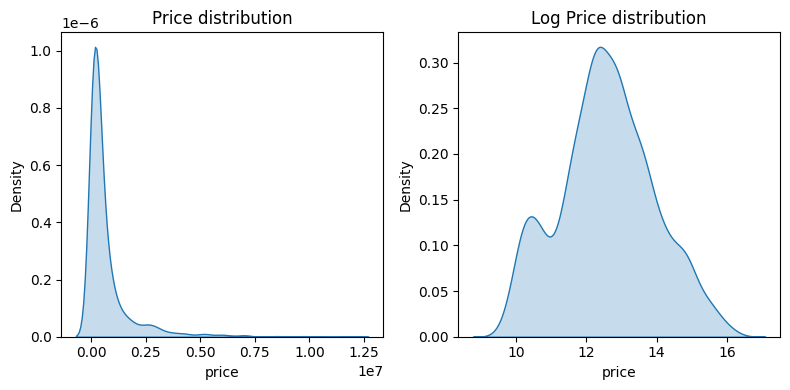

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(Y, ax=axes[0], fill='blue')
axes[0].set_title('Price distribution', fontsize=12)

sns.kdeplot(np.log(Y), ax=axes[1], fill='blue')
axes[1].set_title('Log Price distribution', fontsize=12)

plt.tight_layout()
plt.show()

In [12]:
Y_log = np.log1p(Y)

In [13]:
numerical_cols = ['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']
categorical_cols = X.drop(columns=['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']).columns.tolist()

binary_cat_cols = [
    col for col in categorical_cols
    if df[col].nunique() == 2
]
multi_cat_cols = df[categorical_cols].drop(columns=binary_cat_cols).columns

### Training a Base Model

In [14]:
mlflow.set_experiment("Base Model Label vs OneHot Encoding")

<Experiment: artifact_location='mlflow-artifacts:/727244903144796704', creation_time=1733126963002, experiment_id='727244903144796704', last_update_time=1733126963002, lifecycle_stage='active', name='Base Model Label vs OneHot Encoding', tags={}>

In [15]:
test_results = {}

In [18]:
X_processed = X.copy()

label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X_processed[col] = label_encoders[col].fit_transform(X_processed[col])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test)  
    y_pred_orig = np.expm1(y_pred)  
    
    mlflow.log_param("encoding", "label encoding-dropped_duplicates")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    r2 = r2_score(y_test_orig, y_pred_orig)
    mlflow.log_metric("r2", r2)
    print("r2:", r2)
    
    test_results['model 1'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 683207258206.5504
RMSE: 826563.5233946332
MAE: 301069.6359168832
r2: 0.6118804293470721
Model saved with MLflow
🏃 View run enchanting-lamb-151 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/8ed5f8a38abc477da684281bf0372b89
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


In [19]:
X_processed = X.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test)  
    y_pred_orig = np.expm1(y_pred)  
    
    mlflow.log_param("encoding", "one_hot encoding for all cat cols -dropped_duplicates")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)
    
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    r2 = r2_score(y_test_orig, y_pred_orig)
    mlflow.log_metric("r2", r2)
    print("r2:", r2)
    
    test_results['model 2'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 431932277499.6527
RMSE: 657215.5487354607
MAE: 202273.2476451817
r2: 0.7546258941475935
Model saved with MLflow
🏃 View run overjoyed-carp-428 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/2b35bfda81054ade8b6e8491f949edb2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


In [20]:
X_processed = X.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test) 
    y_pred_orig = np.expm1(y_pred)
    
    mlflow.log_param("encoding", "one_hot encoding for multi cat cols -dropped_duplicates")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)

    r2 = r2_score(y_test_orig, y_pred_orig)
    mlflow.log_metric("r2", r2)
    print("r2:", r2)
    
    test_results['model 3'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 426289880995.5552
RMSE: 652908.7845905852
MAE: 199900.7188273728
r2: 0.7578312531105128
Model saved with MLflow
🏃 View run illustrious-lark-857 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/7e3d0895ebcc481fa20de2775e0cc3e5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


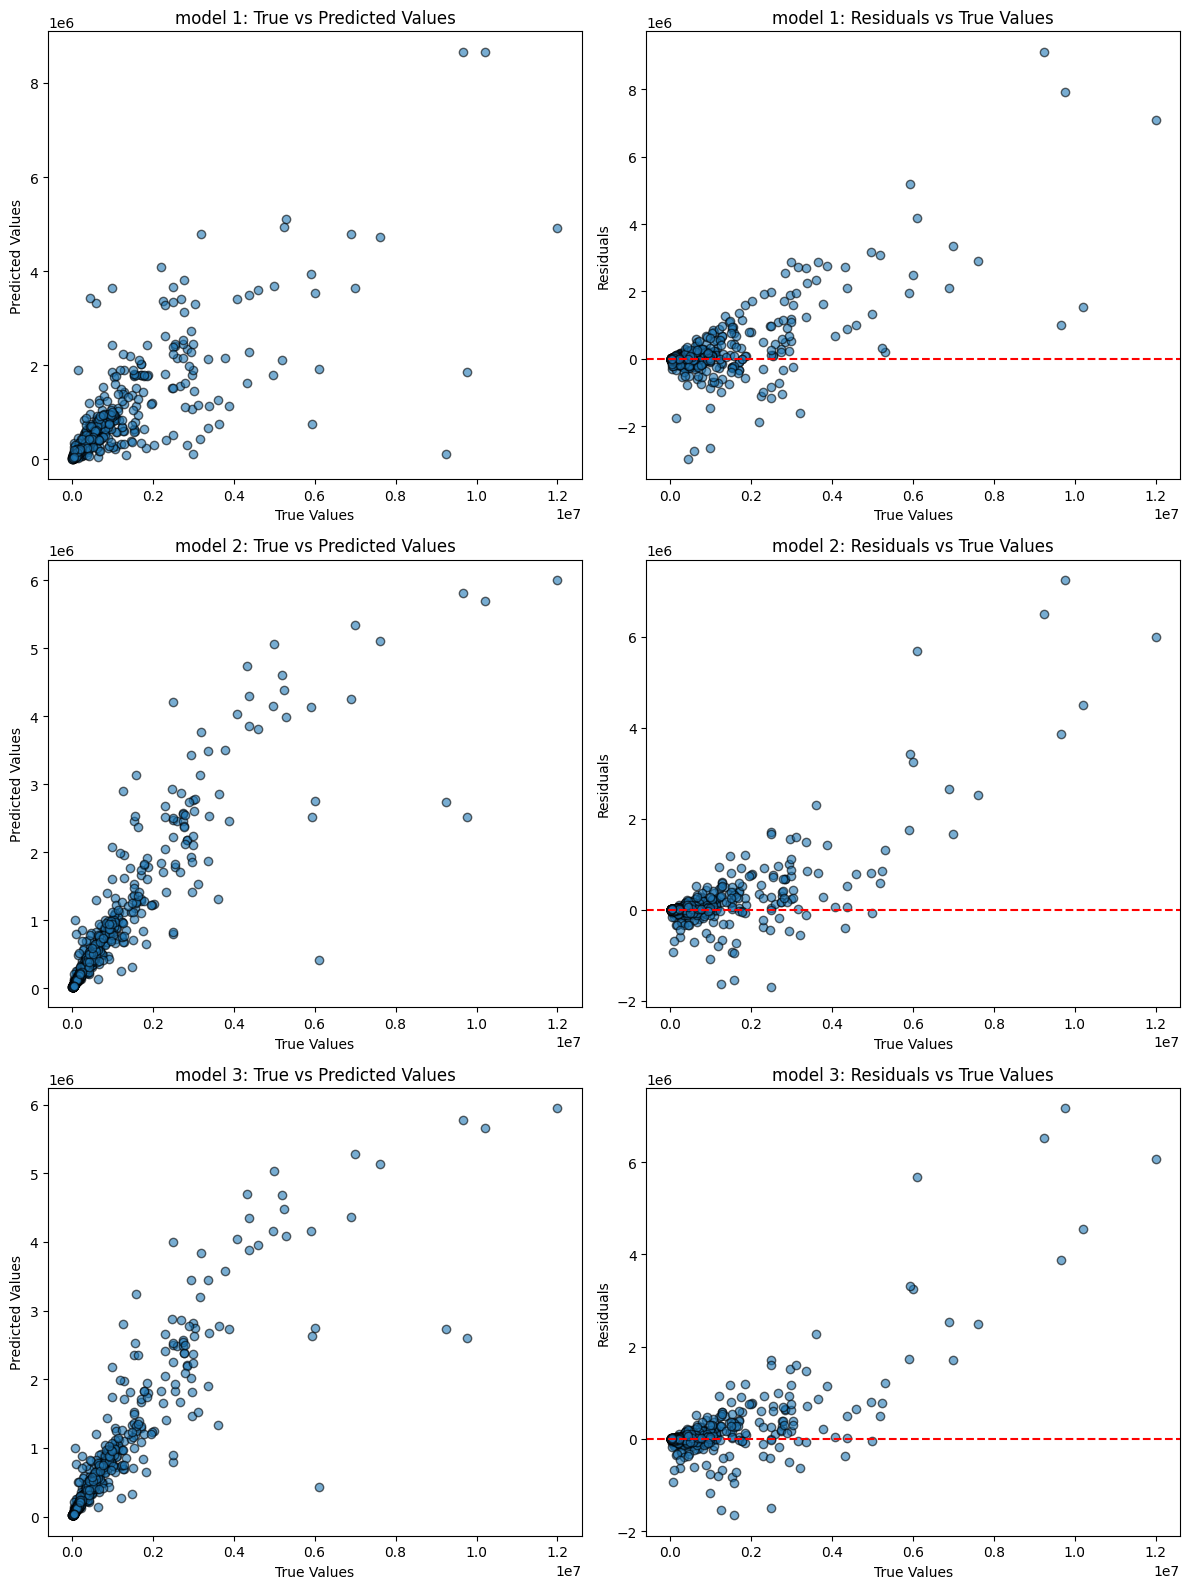

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

for i, model in enumerate(test_results.keys()):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


We can clearly see that OneHot encoding for Multi-class columns shows the best results

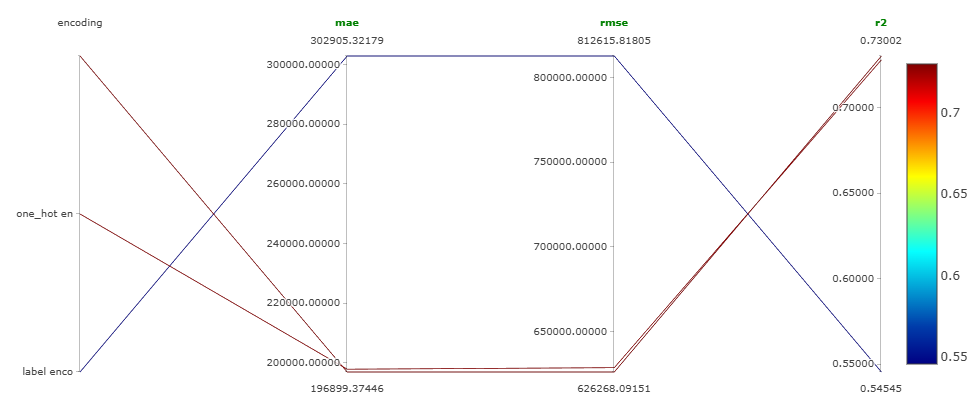

We will calculate all relevant metrics, but prioritize minimizing Mean Squared Error (MSE) because it places greater emphasis on larger errors. This aligns with our goal of creating a model that delivers highly accurate price predictions across all price ranges.

### Experiment 2: Selecting features

In [ ]:
# I have an assumption that luminosity columns don't contribute much to the performance of the model, lets check that

In [22]:
mlflow.set_experiment("Feature Selection")

<Experiment: artifact_location='mlflow-artifacts:/280729109587890328', creation_time=1733129005643, experiment_id='280729109587890328', last_update_time=1733129005643, lifecycle_stage='active', name='Feature Selection', tags={}>

In [23]:
test_results = {}

In [24]:
features = []
stones = []
luminosity = []
regular_col = []

for col in df.columns:
    if 'feature' in col:
        features.append(col)
    elif 'luminosity' in col:
        luminosity.append(col)
    elif 'precious_stone' in col:
        stones.append(col)
    else:
        regular_col.append(col)

In [26]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    y_test_orig = np.expm1(y_test) 
    y_pred_orig = np.expm1(y_pred)
    
    mlflow.log_param("name", "base-dropped_duplicates")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    r2 = r2_score(y_test_orig, y_pred_orig)
    mlflow.log_metric("r2", r2)
    print("r2:", r2)
    
    train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_mse", train_mse)
    print("train_mse:", train_mse)

    train_rmse = np.sqrt(train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    print("train_rmse:", train_rmse) 

    train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_mae", train_mae)
    print("train_mae:", train_mae)
    
    r2 = r2_score(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_r2", r2)
    print("r2:", r2)
    
    test_results[f'model base'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig,
    'y_train':  np.expm1(y_train),
    'y_train_pred': np.expm1(y_train_pred)
    }

    print("Model saved with MLflow")

MSE: 426289880995.5552
RMSE: 652908.7845905852
MAE: 199900.7188273728
r2: 0.7578312531105128
train_mse: 71561435697.67038
train_rmse: 267509.69271723664
train_mae: 75448.7588600728
r2: 0.9489905100893081
Model saved with MLflow
🏃 View run big-chimp-775 at: http://127.0.0.1:5000/#/experiments/280729109587890328/runs/241594c0314240ad94fa530d7669792c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/280729109587890328


In [27]:
for i, col_to_drop in enumerate([luminosity, features, stones]):
    
    X_processed = X.drop(columns=col_to_drop)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    if i == 0:
        name = "lum"
    elif i == 1:
        name = "feat"
    else:
        name = "stones"

    with mlflow.start_run(run_name=f"no {name}"):
        
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_train_pred = pipeline.predict(X_train)

        y_test_orig = np.expm1(y_test) 
        y_pred_orig = np.expm1(y_pred)

        mlflow.log_param("name", name+"-dropped_duplicates")

        mse = mean_squared_error(y_test_orig, y_pred_orig)
        mlflow.log_metric("mse", mse)
        print("MSE:", mse)

        rmse = np.sqrt(mse)
        mlflow.log_metric("rmse", rmse)
        print("RMSE:", rmse)

        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        mlflow.log_metric("mae", mae)
        print("MAE:", mae)
        
        r2 = r2_score(y_test_orig, y_pred_orig)
        mlflow.log_metric("r2", r2)
        print("r2:", r2)

        train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_mse", train_mse)
        print("train_mse:", train_mse)

        train_rmse = np.sqrt(train_mse)
        mlflow.log_metric("train_rmse", train_rmse)
        print("train_rmse:", train_rmse) 

        train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_mae", train_mae)
        print("train_mae:", train_mae)

        r2 = r2_score(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_r2", r2)
        print("r2:", r2)
        
        test_results[f'model {name}'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig,
        'y_train':  np.expm1(y_train),
        'y_train_pred': np.expm1(y_train_pred)
        }

        print("Model saved with MLflow")

MSE: 427331109761.75525
RMSE: 653705.6751794
MAE: 201090.9482160819
r2: 0.7572397470092019
train_mse: 71277846113.19652
train_rmse: 266979.11175445264
train_mae: 75449.5796850598
r2: 0.9491926547207982
Model saved with MLflow
🏃 View run no lum at: http://127.0.0.1:5000/#/experiments/280729109587890328/runs/ae96a6bf7f6f46478965c5a51792216a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/280729109587890328
MSE: 412404939822.0945
RMSE: 642187.6204210842
MAE: 201476.68063992957
r2: 0.765719075351938
train_mse: 75108412609.97375
train_rmse: 274059.1407159662
train_mae: 78310.96274639579
r2: 0.9464622002355767
Model saved with MLflow
🏃 View run no feat at: http://127.0.0.1:5000/#/experiments/280729109587890328/runs/b8349c7d818248879f93873cb96f5431
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/280729109587890328
MSE: 399070374166.87726
RMSE: 631720.1707772812
MAE: 198900.4094475478
r2: 0.7732942376980346
train_mse: 74988967675.84053
train_rmse: 273841.13583579904
train_m

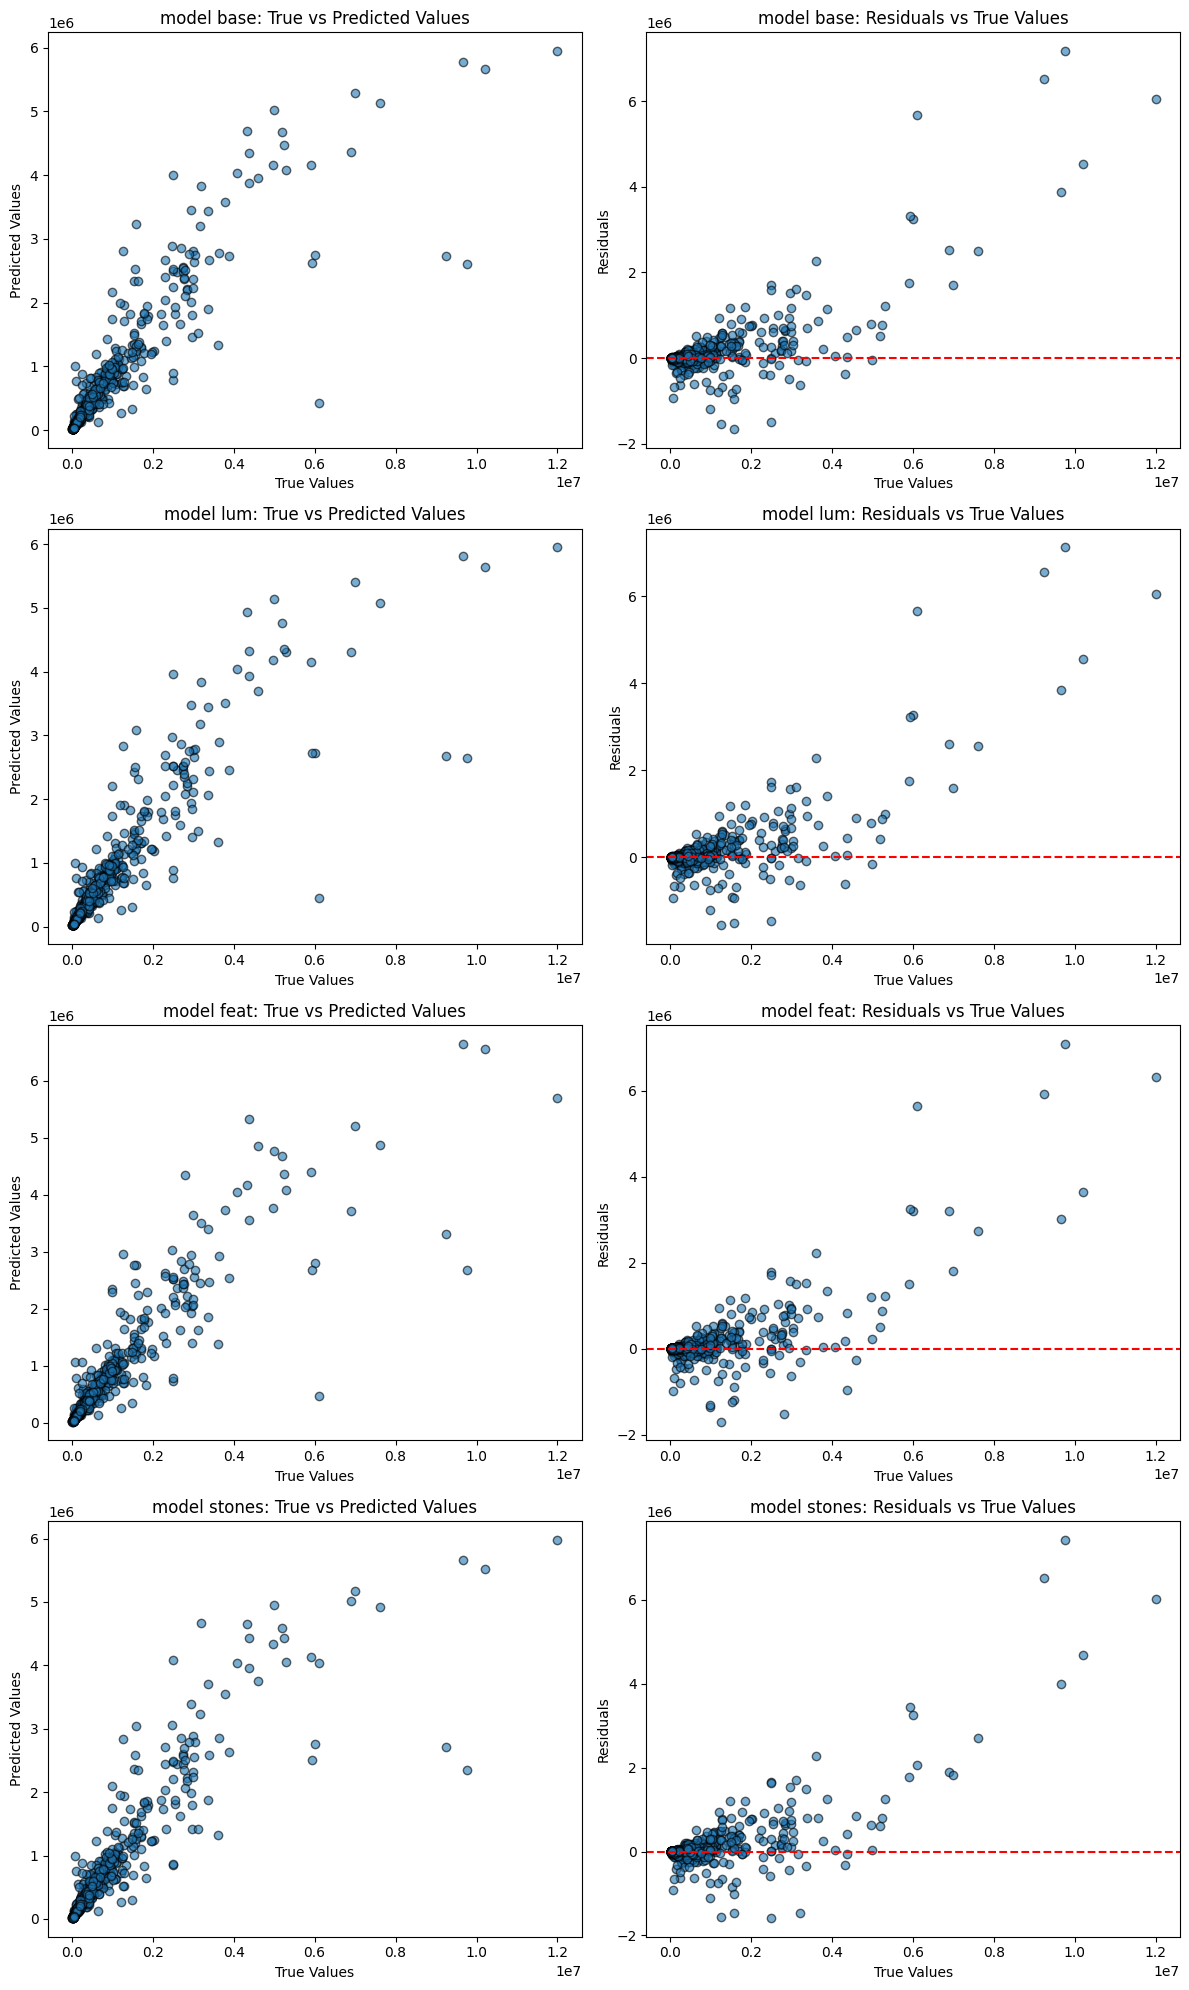

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, model in enumerate(['model base','model lum', 'model feat','model stones']):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


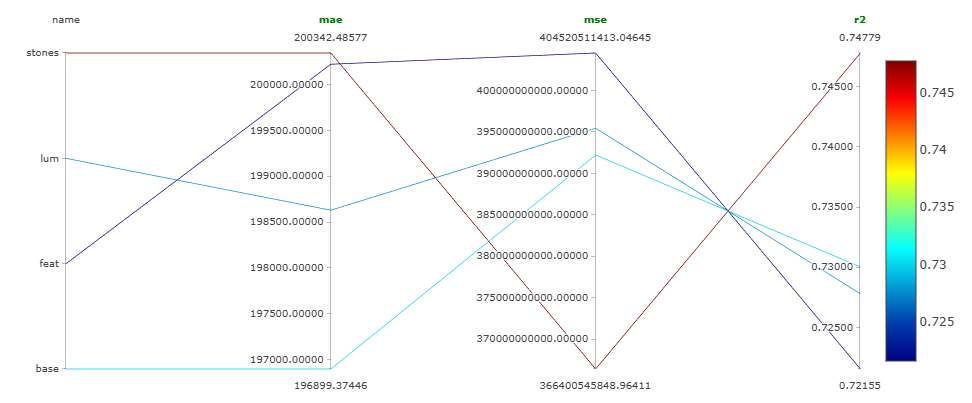

## Cross validation

In [29]:
mlflow.set_experiment("CV features")

<Experiment: artifact_location='mlflow-artifacts:/202848682694580044', creation_time=1733139132819, experiment_id='202848682694580044', last_update_time=1733139132819, lifecycle_stage='active', name='CV features', tags={}>

In [31]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    
    cv_results = cross_validate(
        pipeline, X_processed, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
        cv=5, return_train_score=True
    )

    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
    mean_r2 = cv_results['test_r2'].mean()
    mean_train_r2 = cv_results['train_r2'].mean()


    mlflow.log_param("name", "base-no dups")
    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
    mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
    mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
    mlflow.log_metric("cv_mean_r2", mean_r2)
    mlflow.log_metric("cv_train_mean_r2", mean_train_r2)

    print(f"Model base:")
    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Mean R2:", mean_r2)
    print("CV Train Mean MSE:", mean_train_mse)
    print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
    print("CV Train Mean MAE:", mean_train_mae)
    print("CV Train R2:", mean_train_r2)

Model base:
CV Mean MSE: 0.16627327886251733
CV Mean RMSE: 0.407766206131059
CV Mean MAE: 0.25853416727166867
CV Mean R2: 0.9075978073796257
CV Train Mean MSE: 0.01327473888010502
CV Train Mean RMSE: 0.11521605304863129
CV Train Mean MAE: 0.07072421540212889
CV Train R2: 0.9927396309947742
🏃 View run judicious-horse-952 at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/8e8a84791c94410aae24ec184a5ce50f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044


In [32]:
from sklearn.model_selection import cross_validate

for i, col_to_drop in enumerate([luminosity, features, stones]):
    X_processed = X.drop(columns=col_to_drop)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ]
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    if i == 0:
        name = "lum"
    elif i == 1:
        name = "feat"
    else:
        name = "stones"

    with mlflow.start_run(run_name=f"no {name}"):
        cv_results = cross_validate(
            pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
            cv=5, return_train_score=True
        )

        mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
        mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
        mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
        mean_r2 = cv_results['test_r2'].mean()
        mean_train_r2 = cv_results['train_r2'].mean()


        mlflow.log_param("name", name+"no dups")
        mlflow.log_metric("cv_mean_mse", mean_mse)
        mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
        mlflow.log_metric("cv_mean_mae", mean_mae)
        mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
        mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
        mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
        mlflow.log_metric("cv_mean_r2", mean_r2)
        mlflow.log_metric("cv_train_mean_r2", mean_train_r2)

        print(f"Model {name}:")
        print("CV Mean MSE:", mean_mse)
        print("CV Mean RMSE:", np.sqrt(mean_mse))
        print("CV Mean MAE:", mean_mae)
        print("CV Mean R2:", mean_r2)
        print("CV Train Mean MSE:", mean_train_mse)
        print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
        print("CV Train Mean MAE:", mean_train_mae)
        print("CV Train R2:", mean_train_r2)

Model lum:
CV Mean MSE: 0.16762626641177383
CV Mean RMSE: 0.409421868507013
CV Mean MAE: 0.2593421793379447
CV Mean R2: 0.9068120337115232
CV Train Mean MSE: 0.013301050152620791
CV Train Mean RMSE: 0.11533017884587186
CV Train Mean MAE: 0.07072983484064382
CV Train R2: 0.9927253341568874
🏃 View run no lum at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/a901e3eb1b8f4a4d8a51c53bac6c1d73
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044
Model feat:
CV Mean MSE: 0.17085049892680412
CV Mean RMSE: 0.4133406572390431
CV Mean MAE: 0.26158909094058225
CV Mean R2: 0.9050701324563516
CV Train Mean MSE: 0.013733253241588453
CV Train Mean RMSE: 0.11718896382163489
CV Train Mean MAE: 0.07224326544109658
CV Train R2: 0.9924890034561058
🏃 View run no feat at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/3bf60cfc06a2404da81bc2a9a189fda0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044
Model stones:
CV Mean MSE: 0.165

### Model Selection

In [33]:
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
#             'regressor__fit_intercept': [True, False],
#             'regressor__positive': [False, True]
        }
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
#             'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
#             'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
#             'regressor__fit_intercept': [True, False],
#             'regressor__positive': [False, True]
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
#             'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
#             'regressor__selection': ['cyclic', 'random'],
#             'regressor__fit_intercept': [True, False],
#             'regressor__positive': [False, True]
        }
    },

    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params':
        {
#             'regressor__n_estimators': [200, 300, 500],
#             'regressor__learning_rate': [0.01, 0.1],
#             'regressor__max_depth': [3, 5, 7],
#             'regressor__subsample': [0.8, 0.9, 1.0],
        }
    },
    'SVR': {
        'model': SVR(),
        'params': 
        {
#             'regressor__kernel': ['rbf', 'linear', 'poly'],
#             'regressor__C': [0.1, 1],
#             'regressor__epsilon': [0.1, 0.2],
#             'regressor__gamma': ['scale', 'auto', 0.1, 1],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
#             'regressor__max_depth': [None, 10, 20, 30, 50],
#             'regressor__min_samples_split': [2, 5, 10, 15],
#             'regressor__min_samples_leaf': [1, 2, 4],
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
#             'regressor__n_estimators': [100, 300, 500, 1000, 1500],
#             'regressor__learning_rate': [0.01, 0.1, 0.3],
#             'regressor__max_depth': [3, 5, 7, 10],
#             'regressor__min_child_weight': [1, 3, 5],
#             'regressor__subsample': [0.6, 0.8, 1.0],
#             'regressor__colsample_bytree': [0.6, 0.8, 1.0],
#             'regressor__gamma': [0, 0.1, 0.3],
#             'regressor__reg_alpha': [0, 0.1, 1],
#             'regressor__reg_lambda': [0, 0.1, 1]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {
#             'regressor__iterations': [100, 500, 1000, 1500, 3000],
#             'regressor__learning_rate': [0.01, 0.1, 0.3],
#             'regressor__depth': [4, 6, 8, 10],
#             'regressor__l2_leaf_reg': [1, 3, 5, 10],
#             'regressor__rsm': [0.6, 0.8, 1.0],
#             'regressor__random_strength': [0, 0.1, 1],
#             'regressor__bagging_temperature': [0, 1],
#             'regressor__border_count': [32, 64, 128],
#             'regressor__loss_function': ['RMSE', 'MAE', 'MAPE']
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
#             'regressor__n_estimators': [100, 500, 1000, 1500, 3000],
#             'regressor__learning_rate': [0.01, 0.1, 0.3],
#             'regressor__max_depth': [3, 5, 7, -1],
#             'regressor__num_leaves': [31, 50, 70, 100],
#             'regressor__min_child_samples': [20, 50, 100],
#             'regressor__subsample': [0.6, 0.8, 1.0],
#             'regressor__colsample_bytree': [0.6, 0.8, 1.0],
#             'regressor__reg_alpha': [0, 0.1, 1],
#             'regressor__reg_lambda': [0, 0.1, 1],
#             'regressor__min_split_gain': [0, 0.1, 0.3],
#             'regressor__boosting_type': ['gbdt', 'dart', 'goss']
        }
    },
    
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
#             'regressor__n_estimators': [100, 200, 500],
#             'regressor__max_depth': [None, 10, 20, 30],
#             'regressor__min_samples_split': [2, 5, 10, 15],
#             'regressor__min_samples_leaf': [1, 2, 4],
#             'regressor__max_features': ['auto', 'sqrt', 'log2'],
#             'regressor__bootstrap': [True, False],
#             'regressor__criterion': ['squared_error', 'absolute_error']
        }
    },
}


In [34]:
mlflow.set_experiment("Model Selection")

<Experiment: artifact_location='mlflow-artifacts:/101523853129733287', creation_time=1733142809418, experiment_id='101523853129733287', last_update_time=1733142809418, lifecycle_stage='active', name='Model Selection', tags={}>

In [35]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]

multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

cat_indices = []
cat_feature_mask = X_processed.columns.isin(categorical_cols)
cat_indices = list(np.where(cat_feature_mask)[0])

results = {}

for model_name, model_info in models.items():

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model_info['model'])
    ])

    with mlflow.start_run(run_name=f"experiment_{model_name}"):
        
        print(f"Performing run for model_{model_name}")
        
        cv_results = cross_validate(
            pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
            cv=5, return_train_score=True
        )

        mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
        mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
        mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
        mean_r2 = cv_results['test_r2'].mean()
        mean_train_r2 = cv_results['train_r2'].mean()


        mlflow.log_param("name", model_name+"no dups")
        mlflow.log_metric("cv_mean_mse", mean_mse)
        mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
        mlflow.log_metric("cv_mean_mae", mean_mae)
        mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
        mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
        mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
        mlflow.log_metric("cv_mean_r2", mean_r2)
        mlflow.log_metric("cv_train_mean_r2", mean_train_r2)

        print(f"Model {model_name}:")
        print("CV Mean MSE:", mean_mse)
        print("CV Mean RMSE:", np.sqrt(mean_mse))
        print("CV Mean MAE:", mean_mae)
        print("CV Mean R2:", mean_r2)
        print("CV Train Mean MSE:", mean_train_mse)
        print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
        print("CV Train Mean MAE:", mean_train_mae)
        print("CV Train R2:", mean_train_r2)

Performing run for model_Linear Regression
Model Linear Regression:
CV Mean MSE: 1.1279582698323822e+18
CV Mean RMSE: 1062053797.9934831
CV Mean MAE: 45547346.00525953
CV Mean R2: -6.261533950122365e+17
CV Train Mean MSE: 0.08081388327458464
CV Train Mean RMSE: 0.2842778276169013
CV Train Mean MAE: 0.20750328940187518
CV Train R2: 0.9558201710330948
🏃 View run experiment_Linear Regression at: http://127.0.0.1:5000/#/experiments/101523853129733287/runs/38df807158ef473ca3f93acabe6ce60f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/101523853129733287
Performing run for model_Ridge Regression
Model Ridge Regression:
CV Mean MSE: 0.11690433549058066
CV Mean RMSE: 0.34191276005814797
CV Mean MAE: 0.241509657016821
CV Mean R2: 0.9354494657061114
CV Train Mean MSE: 0.08203731602652385
CV Train Mean RMSE: 0.2864215704630569
CV Train Mean MAE: 0.21005527353455267
CV Train R2: 0.9551504403256479
🏃 View run experiment_Ridge Regression at: http://127.0.0.1:5000/#/experiments/10152385312

  File "C:\Users\Admin\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Admin\anaconda3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Admin\anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Admin\anaconda3\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 2841, number of used features: 120
[LightGBM] [Info] Start training from score 12.643175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 2842, number of used features: 119
[LightGBM] [Info] Start training from score 12.585986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

CatBoost, Xgboost and Ridge regression perform the best. Need to do hypermater tuning on these models to choose the best one.

## Hyperparameter Tuning

In [36]:
mlflow.set_experiment("Hyperparameter tuning")

<Experiment: artifact_location='mlflow-artifacts:/113014624842399351', creation_time=1733209290023, experiment_id='113014624842399351', last_update_time=1733209290023, lifecycle_stage='active', name='Hyperparameter tuning', tags={}>

In [37]:
def objective(trial, X, Y_log, preprocessor, model_name, total_trials):
    if hasattr(objective, 'progress_bar'):
        objective.progress_bar.update(1)
        objective.progress_bar.set_description(f"Running {model_name} - Trial {trial.number}")
   
    if model_name == 'Ridge':
        alpha = trial.suggest_loguniform('regressor__alpha', 0.01, 100.0)
        solver = trial.suggest_categorical('regressor__solver', ['auto', 'cholesky', 'lsqr'])
        fit_intercept = trial.suggest_categorical('regressor__fit_intercept', [True, False])
        positive = trial.suggest_categorical('regressor__positive', [False, True])
        
        model = Ridge(
            alpha=alpha, 
            solver=solver, 
            fit_intercept=fit_intercept, 
#             positive=positive
        )
    
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_categorical('regressor__n_estimators', [500, 1000, 1500])
        learning_rate = trial.suggest_loguniform('regressor__learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('regressor__max_depth', 3, 10)
        min_child_weight = trial.suggest_int('regressor__min_child_weight', 1, 5)
        subsample = trial.suggest_uniform('regressor__subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_uniform('regressor__colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_loguniform('regressor__gamma', 1e-8, 1.0)
        reg_alpha = trial.suggest_loguniform('regressor__reg_alpha', 1e-8, 1.0)
        reg_lambda = trial.suggest_loguniform('regressor__reg_lambda', 1e-8, 1.0)
        
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42
        )
    
    elif model_name == 'CatBoost':
        iterations = trial.suggest_categorical('regressor__iterations', [500, 1000, 1500, 3000])
        learning_rate = trial.suggest_loguniform('regressor__learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('regressor__depth', 4, 10)
        l2_leaf_reg = trial.suggest_int('regressor__l2_leaf_reg', 1, 10)
        rsm = trial.suggest_uniform('regressor__rsm', 0.8, 1.0)
        random_strength = trial.suggest_loguniform('regressor__random_strength', 1e-8, 1.0)
        bagging_temperature = trial.suggest_uniform('regressor__bagging_temperature', 0, 1)
        border_count = trial.suggest_categorical('regressor__border_count', [32, 64, 128])
        loss_function = trial.suggest_categorical('regressor__loss_function', ['RMSE', 'MAE'])
        
        model = CatBoostRegressor(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            rsm=rsm,
            random_strength=random_strength,
            bagging_temperature=bagging_temperature,
            border_count=border_count,
            loss_function=loss_function,
            random_state=42,
            thread_count=-1,
            verbose=0
        )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_results = cross_validate(
        pipeline, X, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=3, return_train_score=True
    )
    return -cv_results['test_neg_mean_squared_error'].mean()

def run_optuna_optimization(X_processed, Y_log, preprocessor, models, n_trials=100):
    
    optuna.logging.enable_default_handler()
    optuna.logging.enable_propagation()
    optuna.logging.set_verbosity(optuna.logging.INFO)
    
    results = {}
    
    total_trials = n_trials * len(models)
    
    global_progress_bar = tqdm(total=total_trials, desc="Optuna Hyperparameter Optimization", 
                                position=0, leave=True)
    
    objective.progress_bar = global_progress_bar    
    
    for model_name in models:
        study = optuna.create_study(direction='minimize', 
                                    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))
        
        objective_with_args = lambda trial: objective(trial, X_processed, Y_log, preprocessor, model_name, total_trials)
        
        print(f"Running Optuna optimization for {model_name}")
        
        trial_results = []
        
        def log_trial_result(study, trial):
            if trial.state == optuna.trial.TrialState.COMPLETE:
                trial_results.append({
                    'number': trial.number,
                    'value': trial.value,
                    'params': trial.params
                })
                logging.info(
                    f"Model: {model_name}, "
                    f"Trial {trial.number}, "
                    f"Value: {trial.value}, "
                    f"Params: {trial.params}"
                )

        
        print(f"Running Optuna optimization for {model_name}")
        study.optimize(
            objective_with_args, 
            n_trials=n_trials,
            callbacks=[log_trial_result]
        )
        
        with mlflow.start_run(run_name=f"optuna_experiment_{model_name}"):
            
            mlflow.log_param("total_trials", study.trials_dataframe().shape[0])
            mlflow.log_param("completed_trials", 
                len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]))
            mlflow.log_param("pruned_trials", 
                len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]))
            
            # Log the best trial information
            best_trial = study.best_trial
            mlflow.log_metric("best_trial_value", best_trial.value)
            mlflow.log_param("best_trial_number", best_trial.number)
       
            best_params = study.best_params
            
            for param, value in best_params.items():
                mlflow.log_param(param, value)
            
            if model_name == 'Ridge':
                best_model = Ridge(
                    alpha=best_params.get('regressor__alpha', 1.0),
                    solver=best_params.get('regressor__solver', 'auto'),
                    fit_intercept=best_params.get('regressor__fit_intercept', True),
                )
            elif model_name == 'XGBoost':
                best_model = XGBRegressor(
                    n_estimators=best_params.get('regressor__n_estimators', 1000),
                    learning_rate=best_params.get('regressor__learning_rate', 0.1),
                    max_depth=best_params.get('regressor__max_depth', 5),
                    min_child_weight=best_params.get('regressor__min_child_weight', 1),
                    subsample=best_params.get('regressor__subsample', 0.8),
                    colsample_bytree=best_params.get('regressor__colsample_bytree', 0.8),
                    gamma=best_params.get('regressor__gamma', 0),
                    reg_alpha=best_params.get('regressor__reg_alpha', 0),
                    reg_lambda=best_params.get('regressor__reg_lambda', 0),
                    random_state=42
                )
            elif model_name == 'CatBoost':
                best_model = CatBoostRegressor(
                    iterations=best_params.get('regressor__iterations', 1000),
                    learning_rate=best_params.get('regressor__learning_rate', 0.1),
                    depth=best_params.get('regressor__depth', 6),
                    l2_leaf_reg=best_params.get('regressor__l2_leaf_reg', 3),
                    rsm=best_params.get('regressor__rsm', 1.0),
                    random_strength=best_params.get('regressor__random_strength', 0),
                    bagging_temperature=best_params.get('regressor__bagging_temperature', 0),
                    border_count=best_params.get('regressor__border_count', 64),
                    loss_function=best_params.get('regressor__loss_function', 'RMSE'),
                    random_state=42,
                    verbose=0
                )
            
            final_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', best_model)
            ])
            
            cv_results = cross_validate(
            final_pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
            cv=5, return_train_score=True
            )

            mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
            mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
            mean_r2 = cv_results['test_r2'].mean()
            mean_train_r2 = cv_results['train_r2'].mean()


            mlflow.log_param("name", model_name)
            mlflow.log_metric("cv_mean_mse", mean_mse)
            mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
            mlflow.log_metric("cv_mean_mae", mean_mae)
            mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
            mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
            mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
            mlflow.log_metric("cv_mean_r2", mean_r2)
            mlflow.log_metric("cv_train_mean_r2", mean_train_r2)

            print(f"Model {model_name}:")
            print("CV Mean MSE:", mean_mse)
            print("CV Mean RMSE:", np.sqrt(mean_mse))
            print("CV Mean MAE:", mean_mae)
            print("CV Mean R2:", mean_r2)
            print("CV Train Mean MSE:", mean_train_mse)
            print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
            print("CV Train Mean MAE:", mean_train_mae)
            print("CV Train R2:", mean_train_r2)
            
    global_progress_bar.close()
    
    return results

In [38]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]

multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

models = ['Ridge', 'XGBoost', 'CatBoost']

results = run_optuna_optimization(
    X_processed, 
    Y_log, 
    preprocessor, 
    models, 
    n_trials=100
)

Optuna Hyperparameter Optimization:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-12-05 17:47:49,489] A new study created in memory with name: no-name-214ebc15-9bc0-414b-8ef8-09e6134f6c3b
[I 2024-12-05 17:47:49,688] Trial 0 finished with value: 0.33518532807667256 and parameters: {'regressor__alpha': 54.304836337918424, 'regressor__solver': 'lsqr', 'regressor__fit_intercept': True, 'regressor__positive': False}. Best is trial 0 with value: 0.33518532807667256.


Running Optuna optimization for Ridge
Running Optuna optimization for Ridge


[W 2024-12-05 17:47:49,823] Trial 1 failed with parameters: {'regressor__alpha': 0.7595068965661289, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:49,826] Trial 1 failed with value nan.
[W 2024-12-05 17:47:49,957] Trial 2 failed with parameters: {'regressor__alpha': 8.263806968131535, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': False} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:49,960] Trial 2 failed with value nan.
[I 2024-12-05 17:47:50,199] Trial 3 finished with value: 0.1536558171986481 and parameters: {'regressor__alpha': 0.942316659084681, 'regressor__solver': 'auto', 'regressor__fit_intercept': False, 'regressor__positive': False}. Best is trial 3 with value: 0.1536558171986481.
INFO:optuna.study.study:Trial 3 finished with value: 0.1536558171986481 and paramet

INFO:optuna.study.study:Trial 15 finished with value: 0.14704302317951085 and parameters: {'regressor__alpha': 0.06723098959843345, 'regressor__solver': 'auto', 'regressor__fit_intercept': True, 'regressor__positive': True}. Best is trial 15 with value: 0.14704302317951085.
[I 2024-12-05 17:47:53,861] Trial 16 finished with value: 0.14689919004450178 and parameters: {'regressor__alpha': 0.10723419250022088, 'regressor__solver': 'auto', 'regressor__fit_intercept': True, 'regressor__positive': True}. Best is trial 16 with value: 0.14689919004450178.
INFO:optuna.study.study:Trial 16 finished with value: 0.14689919004450178 and parameters: {'regressor__alpha': 0.10723419250022088, 'regressor__solver': 'auto', 'regressor__fit_intercept': True, 'regressor__positive': True}. Best is trial 16 with value: 0.14689919004450178.
[I 2024-12-05 17:47:54,114] Trial 17 finished with value: 0.14680938974862454 and parameters: {'regressor__alpha': 0.1322474993379289, 'regressor__solver': 'auto', 'regres

[W 2024-12-05 17:47:56,003] Trial 28 failed with value nan.
[W 2024-12-05 17:47:56,158] Trial 29 failed with parameters: {'regressor__alpha': 0.3262054090064801, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:56,160] Trial 29 failed with value nan.
[W 2024-12-05 17:47:56,333] Trial 30 failed with parameters: {'regressor__alpha': 0.3841057729148113, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:56,335] Trial 30 failed with value nan.
[W 2024-12-05 17:47:56,495] Trial 31 failed with parameters: {'regressor__alpha': 0.38059068357139747, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:56,496] Tr

[W 2024-12-05 17:47:58,043] Trial 41 failed with value nan.
[W 2024-12-05 17:47:58,199] Trial 42 failed with parameters: {'regressor__alpha': 0.41118438920352207, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:58,200] Trial 42 failed with value nan.
[W 2024-12-05 17:47:58,347] Trial 43 failed with parameters: {'regressor__alpha': 0.39140265131387525, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:58,349] Trial 43 failed with value nan.
[W 2024-12-05 17:47:58,509] Trial 44 failed with parameters: {'regressor__alpha': 0.4031087295197876, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:47:58,510] T

[W 2024-12-05 17:48:00,111] Trial 54 failed with parameters: {'regressor__alpha': 0.4612887756244287, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:00,113] Trial 54 failed with value nan.
[W 2024-12-05 17:48:00,242] Trial 55 failed with parameters: {'regressor__alpha': 0.4625544924199022, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:00,243] Trial 55 failed with value nan.
[W 2024-12-05 17:48:00,373] Trial 56 failed with parameters: {'regressor__alpha': 0.3771437800926931, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:00,375] Trial 56 failed with value nan.
[W 2024-12-05 17:48:00,502] Tri

[W 2024-12-05 17:48:01,718] Trial 66 failed with value nan.
[W 2024-12-05 17:48:01,850] Trial 67 failed with parameters: {'regressor__alpha': 0.34500680194178873, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:01,852] Trial 67 failed with value nan.
[W 2024-12-05 17:48:01,992] Trial 68 failed with parameters: {'regressor__alpha': 0.3957773159086425, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:01,994] Trial 68 failed with value nan.
[W 2024-12-05 17:48:02,130] Trial 69 failed with parameters: {'regressor__alpha': 3.081243905588285, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:02,133] Tri

[W 2024-12-05 17:48:03,762] Trial 79 failed with value nan.
[W 2024-12-05 17:48:03,894] Trial 80 failed with parameters: {'regressor__alpha': 0.37901746304048284, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:03,896] Trial 80 failed with value nan.
[W 2024-12-05 17:48:04,037] Trial 81 failed with parameters: {'regressor__alpha': 0.48969691476433835, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:04,039] Trial 81 failed with value nan.
[W 2024-12-05 17:48:04,260] Trial 82 failed with parameters: {'regressor__alpha': 0.3901967860003824, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:04,262] T

[W 2024-12-05 17:48:05,657] Trial 92 failed with parameters: {'regressor__alpha': 0.4089124218571674, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:05,659] Trial 92 failed with value nan.
[W 2024-12-05 17:48:05,790] Trial 93 failed with parameters: {'regressor__alpha': 0.4571637224250785, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:05,792] Trial 93 failed with value nan.
[W 2024-12-05 17:48:05,929] Trial 94 failed with parameters: {'regressor__alpha': 0.4374545555980343, 'regressor__solver': 'cholesky', 'regressor__fit_intercept': True, 'regressor__positive': True} because of the following error: The value nan is not acceptable.
[W 2024-12-05 17:48:05,931] Trial 94 failed with value nan.
[W 2024-12-05 17:48:06,063] Tri

Model Ridge:
CV Mean MSE: 0.16627327886251733
CV Mean RMSE: 0.407766206131059
CV Mean MAE: 0.25853416727166867
CV Mean R2: 0.9075978073796257
CV Train Mean MSE: 0.01327473888010502
CV Train Mean RMSE: 0.11521605304863129
CV Train Mean MAE: 0.07072421540212889
CV Train R2: 0.9927396309947742
🏃 View run optuna_experiment_Ridge at: http://127.0.0.1:5000/#/experiments/113014624842399351/runs/a0bd999a48d3479fa9ed3663e87bfe12
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/113014624842399351
Running Optuna optimization for XGBoost
Running Optuna optimization for XGBoost


[I 2024-12-05 17:49:54,651] Trial 0 finished with value: 0.16257928299002536 and parameters: {'regressor__n_estimators': 500, 'regressor__learning_rate': 0.028548988483135352, 'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.9235544550169794, 'regressor__colsample_bytree': 0.8549941110752715, 'regressor__gamma': 0.2681204913950446, 'regressor__reg_alpha': 0.0003036183886532016, 'regressor__reg_lambda': 0.7628338547372959}. Best is trial 0 with value: 0.16257928299002536.
INFO:optuna.study.study:Trial 0 finished with value: 0.16257928299002536 and parameters: {'regressor__n_estimators': 500, 'regressor__learning_rate': 0.028548988483135352, 'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.9235544550169794, 'regressor__colsample_bytree': 0.8549941110752715, 'regressor__gamma': 0.2681204913950446, 'regressor__reg_alpha': 0.0003036183886532016, 'regressor__reg_lambda': 0.7628338547372959}. Best is trial 0 with valu

[I 2024-12-05 17:50:59,194] Trial 8 finished with value: 0.1286870449870353 and parameters: {'regressor__n_estimators': 1000, 'regressor__learning_rate': 0.03292187119575571, 'regressor__max_depth': 6, 'regressor__min_child_weight': 5, 'regressor__subsample': 0.9041082405307205, 'regressor__colsample_bytree': 0.7181283695910734, 'regressor__gamma': 0.0026138743415147162, 'regressor__reg_alpha': 0.0029539055958836915, 'regressor__reg_lambda': 0.04238822392356844}. Best is trial 8 with value: 0.1286870449870353.
INFO:optuna.study.study:Trial 8 finished with value: 0.1286870449870353 and parameters: {'regressor__n_estimators': 1000, 'regressor__learning_rate': 0.03292187119575571, 'regressor__max_depth': 6, 'regressor__min_child_weight': 5, 'regressor__subsample': 0.9041082405307205, 'regressor__colsample_bytree': 0.7181283695910734, 'regressor__gamma': 0.0026138743415147162, 'regressor__reg_alpha': 0.0029539055958836915, 'regressor__reg_lambda': 0.04238822392356844}. Best is trial 8 with

[I 2024-12-05 17:51:50,793] Trial 16 finished with value: 0.12652932479518222 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.09910803058446994, 'regressor__max_depth': 4, 'regressor__min_child_weight': 4, 'regressor__subsample': 0.6662203923909681, 'regressor__colsample_bytree': 0.750856050506304, 'regressor__gamma': 2.843692337802231e-07, 'regressor__reg_alpha': 1.0250235177393912e-06, 'regressor__reg_lambda': 0.00011886998992343748}. Best is trial 14 with value: 0.12023284465391733.
INFO:optuna.study.study:Trial 16 finished with value: 0.12652932479518222 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.09910803058446994, 'regressor__max_depth': 4, 'regressor__min_child_weight': 4, 'regressor__subsample': 0.6662203923909681, 'regressor__colsample_bytree': 0.750856050506304, 'regressor__gamma': 2.843692337802231e-07, 'regressor__reg_alpha': 1.0250235177393912e-06, 'regressor__reg_lambda': 0.00011886998992343748}. Best is 

[I 2024-12-05 17:52:55,431] Trial 24 finished with value: 0.1301630860813318 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.026385208523458402, 'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.8351326963796913, 'regressor__colsample_bytree': 0.9121252430072578, 'regressor__gamma': 3.6976143074387236e-06, 'regressor__reg_alpha': 0.0005972710183409588, 'regressor__reg_lambda': 2.223180506743439e-05}. Best is trial 14 with value: 0.12023284465391733.
INFO:optuna.study.study:Trial 24 finished with value: 0.1301630860813318 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.026385208523458402, 'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.8351326963796913, 'regressor__colsample_bytree': 0.9121252430072578, 'regressor__gamma': 3.6976143074387236e-06, 'regressor__reg_alpha': 0.0005972710183409588, 'regressor__reg_lambda': 2.223180506743439e-05}. Best is 

[I 2024-12-05 17:54:13,475] Trial 32 finished with value: 0.1290727561943046 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.03351716443822605, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.9199634224711264, 'regressor__colsample_bytree': 0.8305357222668561, 'regressor__gamma': 1.0503885135680833e-07, 'regressor__reg_alpha': 4.814610585668754e-05, 'regressor__reg_lambda': 4.039383168067691e-05}. Best is trial 14 with value: 0.12023284465391733.
INFO:optuna.study.study:Trial 32 finished with value: 0.1290727561943046 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.03351716443822605, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.9199634224711264, 'regressor__colsample_bytree': 0.8305357222668561, 'regressor__gamma': 1.0503885135680833e-07, 'regressor__reg_alpha': 4.814610585668754e-05, 'regressor__reg_lambda': 4.039383168067691e-05}. Best is tr

[I 2024-12-05 17:55:02,443] Trial 40 finished with value: 0.17459668020174604 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.0399914609695774, 'regressor__max_depth': 7, 'regressor__min_child_weight': 3, 'regressor__subsample': 0.8558336137620633, 'regressor__colsample_bytree': 0.8999207705276755, 'regressor__gamma': 0.6556822075434132, 'regressor__reg_alpha': 0.002685063486700866, 'regressor__reg_lambda': 1.9475438736035256e-06}. Best is trial 14 with value: 0.12023284465391733.
INFO:optuna.study.study:Trial 40 finished with value: 0.17459668020174604 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.0399914609695774, 'regressor__max_depth': 7, 'regressor__min_child_weight': 3, 'regressor__subsample': 0.8558336137620633, 'regressor__colsample_bytree': 0.8999207705276755, 'regressor__gamma': 0.6556822075434132, 'regressor__reg_alpha': 0.002685063486700866, 'regressor__reg_lambda': 1.9475438736035256e-06}. Best is trial 14 w

[I 2024-12-05 17:55:55,610] Trial 48 finished with value: 0.12029814771814923 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.06110141776094754, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.8165196207760064, 'regressor__colsample_bytree': 0.7359389709537758, 'regressor__gamma': 6.370258175210308e-05, 'regressor__reg_alpha': 0.0012631820161687869, 'regressor__reg_lambda': 0.001328635172132215}. Best is trial 43 with value: 0.11853995844063137.
INFO:optuna.study.study:Trial 48 finished with value: 0.12029814771814923 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.06110141776094754, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.8165196207760064, 'regressor__colsample_bytree': 0.7359389709537758, 'regressor__gamma': 6.370258175210308e-05, 'regressor__reg_alpha': 0.0012631820161687869, 'regressor__reg_lambda': 0.001328635172132215}. Best is tria

[I 2024-12-05 17:57:04,669] Trial 56 finished with value: 0.12280643030112977 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.06289769158902705, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.6933323202311694, 'regressor__colsample_bytree': 0.7829685076792205, 'regressor__gamma': 0.05865202708077922, 'regressor__reg_alpha': 0.028112861619085484, 'regressor__reg_lambda': 0.0011057028393275338}. Best is trial 43 with value: 0.11853995844063137.
INFO:optuna.study.study:Trial 56 finished with value: 0.12280643030112977 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.06289769158902705, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.6933323202311694, 'regressor__colsample_bytree': 0.7829685076792205, 'regressor__gamma': 0.05865202708077922, 'regressor__reg_alpha': 0.028112861619085484, 'regressor__reg_lambda': 0.0011057028393275338}. Best is trial 43

[I 2024-12-05 17:58:01,342] Trial 64 finished with value: 0.12826668482013734 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.10322627875675282, 'regressor__max_depth': 4, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.6226884256656756, 'regressor__colsample_bytree': 0.8065997954568926, 'regressor__gamma': 7.573823298976416e-08, 'regressor__reg_alpha': 0.00031253901858231567, 'regressor__reg_lambda': 0.002401480186577006}. Best is trial 43 with value: 0.11853995844063137.
INFO:optuna.study.study:Trial 64 finished with value: 0.12826668482013734 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.10322627875675282, 'regressor__max_depth': 4, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.6226884256656756, 'regressor__colsample_bytree': 0.8065997954568926, 'regressor__gamma': 7.573823298976416e-08, 'regressor__reg_alpha': 0.00031253901858231567, 'regressor__reg_lambda': 0.002401480186577006}. Best is tr

[I 2024-12-05 17:58:50,855] Trial 72 finished with value: 0.11873499796425215 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.056103465192165046, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.8022715279340309, 'regressor__colsample_bytree': 0.7200347673402836, 'regressor__gamma': 2.9191866672223903e-08, 'regressor__reg_alpha': 4.42562827005879e-05, 'regressor__reg_lambda': 3.960027526827765e-08}. Best is trial 43 with value: 0.11853995844063137.
INFO:optuna.study.study:Trial 72 finished with value: 0.11873499796425215 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.056103465192165046, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.8022715279340309, 'regressor__colsample_bytree': 0.7200347673402836, 'regressor__gamma': 2.9191866672223903e-08, 'regressor__reg_alpha': 4.42562827005879e-05, 'regressor__reg_lambda': 3.960027526827765e-08}. Best is 

[I 2024-12-05 17:59:58,562] Trial 80 finished with value: 0.1223594657344863 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.05491093422199485, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.7925749869482561, 'regressor__colsample_bytree': 0.7368732919250114, 'regressor__gamma': 4.798017054108837e-07, 'regressor__reg_alpha': 1.298691927151358e-05, 'regressor__reg_lambda': 1.1923749870299151e-08}. Best is trial 73 with value: 0.11752846731929416.
INFO:optuna.study.study:Trial 80 finished with value: 0.1223594657344863 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.05491093422199485, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.7925749869482561, 'regressor__colsample_bytree': 0.7368732919250114, 'regressor__gamma': 4.798017054108837e-07, 'regressor__reg_alpha': 1.298691927151358e-05, 'regressor__reg_lambda': 1.1923749870299151e-08}. Best is tr

[I 2024-12-05 18:00:45,806] Trial 88 finished with value: 0.12368365700471846 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.1663237458534847, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.7276235501858744, 'regressor__colsample_bytree': 0.6403257055134256, 'regressor__gamma': 8.775488019730422e-08, 'regressor__reg_alpha': 4.347474225572312e-06, 'regressor__reg_lambda': 1.1477494408541711e-07}. Best is trial 87 with value: 0.11452727333812367.
INFO:optuna.study.study:Trial 88 finished with value: 0.12368365700471846 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.1663237458534847, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.7276235501858744, 'regressor__colsample_bytree': 0.6403257055134256, 'regressor__gamma': 8.775488019730422e-08, 'regressor__reg_alpha': 4.347474225572312e-06, 'regressor__reg_lambda': 1.1477494408541711e-07}. Best is tr

[I 2024-12-05 18:01:48,419] Trial 96 finished with value: 0.1213001223711398 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.11637675910782805, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.7634712225362397, 'regressor__colsample_bytree': 0.6406691753378957, 'regressor__gamma': 2.9052222109238202e-08, 'regressor__reg_alpha': 4.827192783730872e-07, 'regressor__reg_lambda': 2.2266059908879023e-08}. Best is trial 94 with value: 0.1140089339105408.
INFO:optuna.study.study:Trial 96 finished with value: 0.1213001223711398 and parameters: {'regressor__n_estimators': 1500, 'regressor__learning_rate': 0.11637675910782805, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__subsample': 0.7634712225362397, 'regressor__colsample_bytree': 0.6406691753378957, 'regressor__gamma': 2.9052222109238202e-08, 'regressor__reg_alpha': 4.827192783730872e-07, 'regressor__reg_lambda': 2.2266059908879023e-08}. Best is t

Model XGBoost:
CV Mean MSE: 0.16627327886251733
CV Mean RMSE: 0.407766206131059
CV Mean MAE: 0.25853416727166867
CV Mean R2: 0.9075978073796257
CV Train Mean MSE: 0.01327473888010502
CV Train Mean RMSE: 0.11521605304863129
CV Train Mean MAE: 0.07072421540212889
CV Train R2: 0.9927396309947742
🏃 View run optuna_experiment_XGBoost at: http://127.0.0.1:5000/#/experiments/113014624842399351/runs/a6d8afc8793942c093fe505f35b4a18c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/113014624842399351


[I 2024-12-05 18:03:41,710] A new study created in memory with name: no-name-64d10c4c-7a4e-4c68-acf6-a254fbfbfd74
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-64d10c4c-7a4e-4c68-acf6-a254fbfbfd74


Running Optuna optimization for CatBoost
Running Optuna optimization for CatBoost


[I 2024-12-05 18:04:48,748] Trial 0 finished with value: 0.14785814430393282 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.04686069889096945, 'regressor__depth': 7, 'regressor__l2_leaf_reg': 2, 'regressor__rsm': 0.9904556954219821, 'regressor__random_strength': 1.4819315805822036e-05, 'regressor__bagging_temperature': 0.706866752455414, 'regressor__border_count': 32, 'regressor__loss_function': 'MAE'}. Best is trial 0 with value: 0.14785814430393282.
INFO:optuna.study.study:Trial 0 finished with value: 0.14785814430393282 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.04686069889096945, 'regressor__depth': 7, 'regressor__l2_leaf_reg': 2, 'regressor__rsm': 0.9904556954219821, 'regressor__random_strength': 1.4819315805822036e-05, 'regressor__bagging_temperature': 0.706866752455414, 'regressor__border_count': 32, 'regressor__loss_function': 'MAE'}. Best is trial 0 with value: 0.14785814430393282.
[I 2024-12-05 18:04:57,007] Tr

INFO:optuna.study.study:Trial 8 finished with value: 0.1576460188188423 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.012265451778827681, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 9, 'regressor__rsm': 0.8118455782517765, 'regressor__random_strength': 0.02887932594485209, 'regressor__bagging_temperature': 0.28656083747342287, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 4 with value: 0.12970086801600952.
[I 2024-12-05 18:10:23,946] Trial 9 finished with value: 0.1454345479586494 and parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.015892144102600873, 'regressor__depth': 8, 'regressor__l2_leaf_reg': 1, 'regressor__rsm': 0.9816756560062427, 'regressor__random_strength': 1.7333519420614728e-08, 'regressor__bagging_temperature': 0.42080147904408605, 'regressor__border_count': 32, 'regressor__loss_function': 'RMSE'}. Best is trial 4 with value: 0.12970086801600952.
INFO:optuna.study.study:Tri

[I 2024-12-05 18:13:08,400] Trial 17 finished with value: 0.10868070136914798 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.15384578805514082, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 4, 'regressor__rsm': 0.8338871046032156, 'regressor__random_strength': 0.04916683399030366, 'regressor__bagging_temperature': 0.6839539771060776, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Trial 17 finished with value: 0.10868070136914798 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.15384578805514082, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 4, 'regressor__rsm': 0.8338871046032156, 'regressor__random_strength': 0.04916683399030366, 'regressor__bagging_temperature': 0.6839539771060776, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:13:29,038] 

INFO:optuna.study.study:Trial 25 finished with value: 0.10491300903457872 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.10631902750547831, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.89989758357402, 'regressor__random_strength': 0.008096574385974706, 'regressor__bagging_temperature': 0.6056755858162051, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:18:54,146] Trial 26 finished with value: 0.1694909997765869 and parameters: {'regressor__iterations': 500, 'regressor__learning_rate': 0.10571538932302121, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.9114514381490979, 'regressor__random_strength': 0.00993593063103038, 'regressor__bagging_temperature': 0.34397649539506986, 'regressor__border_count': 64, 'regressor__loss_function': 'MAE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Trial 2

[I 2024-12-05 18:22:40,077] Trial 34 finished with value: 0.1631481312469286 and parameters: {'regressor__iterations': 500, 'regressor__learning_rate': 0.10181327240610043, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 6, 'regressor__rsm': 0.8203251224881836, 'regressor__random_strength': 1.1742444407547016e-05, 'regressor__bagging_temperature': 0.8983167370233744, 'regressor__border_count': 64, 'regressor__loss_function': 'MAE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Trial 34 finished with value: 0.1631481312469286 and parameters: {'regressor__iterations': 500, 'regressor__learning_rate': 0.10181327240610043, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 6, 'regressor__rsm': 0.8203251224881836, 'regressor__random_strength': 1.1742444407547016e-05, 'regressor__bagging_temperature': 0.8983167370233744, 'regressor__border_count': 64, 'regressor__loss_function': 'MAE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:23:11,569] 

INFO:optuna.study.study:Trial 42 finished with value: 0.10461621088529764 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.2042389624473424, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.8441526964893551, 'regressor__random_strength': 0.36226868420800823, 'regressor__bagging_temperature': 0.8189639226760392, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:27:01,925] Trial 43 finished with value: 0.10814041387170681 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.13449982693740492, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 9, 'regressor__rsm': 0.8430722089266185, 'regressor__random_strength': 0.30993722378305316, 'regressor__bagging_temperature': 0.8224736747705966, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Tri

[I 2024-12-05 18:31:07,270] Trial 51 finished with value: 0.10616815044317429 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.23714549151006664, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.8168413347489304, 'regressor__random_strength': 0.8469615619666182, 'regressor__bagging_temperature': 0.779922156471941, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Trial 51 finished with value: 0.10616815044317429 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.23714549151006664, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.8168413347489304, 'regressor__random_strength': 0.8469615619666182, 'regressor__bagging_temperature': 0.779922156471941, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:31:39,917] Tr

INFO:optuna.study.study:Trial 59 finished with value: 0.12018804717048714 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.29705790173955465, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 6, 'regressor__rsm': 0.8589513046169116, 'regressor__random_strength': 1.8454276166002424e-06, 'regressor__bagging_temperature': 0.5826692046773799, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:37:36,235] Trial 60 finished with value: 0.25207302507073576 and parameters: {'regressor__iterations': 1000, 'regressor__learning_rate': 0.01059903244202052, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 4, 'regressor__rsm': 0.8736766326918403, 'regressor__random_strength': 9.186660615309866e-08, 'regressor__bagging_temperature': 0.42293537598766195, 'regressor__border_count': 128, 'regressor__loss_function': 'MAE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.stud

[I 2024-12-05 18:42:20,238] Trial 68 finished with value: 0.12559809960029103 and parameters: {'regressor__iterations': 500, 'regressor__learning_rate': 0.1865102333753599, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.9039456214505706, 'regressor__random_strength': 0.008377305357211023, 'regressor__bagging_temperature': 0.6280988731185994, 'regressor__border_count': 32, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Trial 68 finished with value: 0.12559809960029103 and parameters: {'regressor__iterations': 500, 'regressor__learning_rate': 0.1865102333753599, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.9039456214505706, 'regressor__random_strength': 0.008377305357211023, 'regressor__bagging_temperature': 0.6280988731185994, 'regressor__border_count': 32, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:42:49,893] Tr

INFO:optuna.study.study:Trial 76 finished with value: 0.10995323901566066 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.19552824581132855, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 6, 'regressor__rsm': 0.8160387507504958, 'regressor__random_strength': 0.0015058982212785683, 'regressor__bagging_temperature': 0.22738562648995608, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:47:25,283] Trial 77 finished with value: 0.1086870463281343 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.1722999875549529, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.8214160127137726, 'regressor__random_strength': 0.0004047859759083899, 'regressor__bagging_temperature': 0.6606062636347672, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:

[I 2024-12-05 18:51:16,261] Trial 85 finished with value: 0.1117555041916876 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.13327359257790303, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.8255517804403497, 'regressor__random_strength': 0.0796400748344801, 'regressor__bagging_temperature': 0.5808653113417794, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Trial 85 finished with value: 0.1117555041916876 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.13327359257790303, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.8255517804403497, 'regressor__random_strength': 0.0796400748344801, 'regressor__bagging_temperature': 0.5808653113417794, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:51:22,820] Tr

INFO:optuna.study.study:Trial 93 finished with value: 0.12231541195438689 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.27339959715426526, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 4, 'regressor__rsm': 0.8007726511757706, 'regressor__random_strength': 0.44559472605244327, 'regressor__bagging_temperature': 0.22308125219073893, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
[I 2024-12-05 18:55:06,461] Trial 94 finished with value: 0.11060439122498482 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.14666819184743968, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 2, 'regressor__rsm': 0.8221210843473459, 'regressor__random_strength': 0.10743652858092759, 'regressor__bagging_temperature': 0.0992769091961356, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 11 with value: 0.10275267778586206.
INFO:optuna.study.study:Tri

Model CatBoost:
CV Mean MSE: 0.16627327886251733
CV Mean RMSE: 0.407766206131059
CV Mean MAE: 0.25853416727166867
CV Mean R2: 0.9075978073796257
CV Train Mean MSE: 0.01327473888010502
CV Train Mean RMSE: 0.11521605304863129
CV Train Mean MAE: 0.07072421540212889
CV Train R2: 0.9927396309947742
🏃 View run optuna_experiment_CatBoost at: http://127.0.0.1:5000/#/experiments/113014624842399351/runs/0e76bf6cc2b4416a90e7dcb224a9f4f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/113014624842399351


Through experimentations, we found that the CatBoost performs the best even after hyperparameter tuning

In [40]:
mlflow.set_experiment("Manual Tuning")

<Experiment: artifact_location='mlflow-artifacts:/487140566403542757', creation_time=1733216554797, experiment_id='487140566403542757', last_update_time=1733216554797, lifecycle_stage='active', name='Manual Tuning', tags={}>

In [ ]:
'regressor__iterations': 1500, 
'regressor__learning_rate': 0.1642852035875127, 
'regressor__depth': 4, 'regressor__l2_leaf_reg': 4, 
'regressor__rsm': 0.8263126640848959, 
'regressor__random_strength': 0.658651292068157, 
'regressor__bagging_temperature': 0.12208059366638693, 
'regressor__border_count': 64, 
'regressor__loss_function': 'RMSE'

In [43]:
# Manually tweaking some parameters because I didn't get the best values from optuna(low number of trials)

X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]

multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

with mlflow.start_run():

    model_name = 'CatBoost'

    params = {
        'iterations': 1500,
        'learning_rate':  0.1642852035875127,
        'depth': 4,
        'l2_leaf_reg': 4,
        'rsm': 0.8263126640848959,
        'random_strength': 0.658651292068157,
        'bagging_temperature': 0.12208059366638693,
        'border_count': 64,
        'verbose':0,
        'loss_function': 'RMSE'
    }

    model = CatBoostRegressor(**params)

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    cv_results = cross_validate(
            final_pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
            cv=5, return_train_score=True
        )
    mlflow.log_param('model', model_name+"12")
    mlflow.log_params(params)
    
    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
    mean_r2 = cv_results['test_r2'].mean()
    mean_train_r2 = cv_results['train_r2'].mean()

    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
    mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
    mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
    mlflow.log_metric("cv_mean_r2", mean_r2)
    mlflow.log_metric("cv_train_mean_r2", mean_train_r2)

    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Mean R2:", mean_r2)
    print("CV Train Mean MSE:", mean_train_mse)
    print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
    print("CV Train Mean MAE:", mean_train_mae)
    print("CV Train R2:", mean_train_r2)

CV Mean MSE: 0.08077662707073172
CV Mean RMSE: 0.2842122922583253
CV Mean MAE: 0.194647545732978
CV Mean R2: 0.9550733313718668
CV Train Mean MSE: 0.0120560650296194
CV Train Mean RMSE: 0.10980011397817126
CV Train Mean MAE: 0.08208214005996455
CV Train R2: 0.9934001925570206
🏃 View run treasured-ray-845 at: http://127.0.0.1:5000/#/experiments/487140566403542757/runs/3303e624296f49ddb07a973e95aa5f84
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/487140566403542757


In [9]:
experiment_name = "Manual Tuning"
experiment = mlflow.get_experiment_by_name(experiment_name)

runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, 
                          filter_string='', 
                          run_view_type=mlflow.entities.ViewType.ALL)
best_run = runs.loc[runs['metrics.cv_mean_rmse'].idxmin()]

In [44]:
# params = {
#         'iterations': int(best_run.loc['params.iterations']),
#         'learning_rate': float(best_run.loc['params.learning_rate']),
#         'depth': int(best_run.loc['params.depth']),
#         'l2_leaf_reg': int(best_run.loc['params.l2_leaf_reg']),
#         'rsm': float(best_run.loc['params.rsm']),
#         'random_strength': float(best_run.loc['params.random_strength']),
#         'bagging_temperature': float(best_run.loc['params.bagging_temperature']),
#         'border_count': int(best_run.loc['params.border_count']),
#         'verbose':0,
#         'loss_function': best_run.loc['params.loss_function']
#     }

params = {
        'iterations': 1500,
        'learning_rate':  0.1642852035875127,
        'depth': 4,
        'l2_leaf_reg': 4,
        'rsm': 0.8263126640848959,
        'random_strength': 0.658651292068157,
        'bagging_temperature': 0.12208059366638693,
        'border_count': 64,
        'verbose':0,
        'loss_function': 'RMSE'
    }

## Feature Importance and Selection

In [45]:
mlflow.set_experiment("Checking feature imp")

<Experiment: artifact_location='mlflow-artifacts:/730294856138610483', creation_time=1733218113613, experiment_id='730294856138610483', last_update_time=1733218113613, lifecycle_stage='active', name='Checking feature imp', tags={}>

In [46]:
cols_to_drop = [[], luminosity, stones, features]

for col in cols_to_drop:
    with mlflow.start_run():

        X_processed = X.drop(columns=col)

        binary_cat_cols = [
            col for col in X_processed.columns
            if X_processed[col].nunique() == 2
        ]
        multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

        preprocessor = ColumnTransformer(
            transformers=[
                ('num_scaler', StandardScaler(), numerical_cols),
                ('binary_cols', 'passthrough', binary_cat_cols),
                ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
            ])

        model_name = 'CatBoost'

        model = CatBoostRegressor(**params)

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        if col:
            mlflow.log_param('model', model_name+"_no_lum")
        else:
            mlflow.log_param('model', model_name+"with_lum")
            
        cv_results = cross_validate(
                pipeline, X_processed, Y_log, 
                scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                cv=5, return_train_score=True
            )

        mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
        mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
        mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
        mean_r2 = cv_results['test_r2'].mean()
        mean_train_r2 = cv_results['train_r2'].mean()


        mlflow.log_metric("cv_mean_mse", mean_mse)
        mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
        mlflow.log_metric("cv_mean_mae", mean_mae)
        mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
        mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
        mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
        mlflow.log_metric("cv_mean_r2", mean_r2)
        mlflow.log_metric("cv_train_mean_r2", mean_train_r2)

        print(f"Dropped features {col}:")
        print("CV Mean MSE:", mean_mse)
        print("CV Mean RMSE:", np.sqrt(mean_mse))
        print("CV Mean MAE:", mean_mae)
        print("CV Mean R2:", mean_r2)
        print("CV Train Mean MSE:", mean_train_mse)
        print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
        print("CV Train Mean MAE:", mean_train_mae)
        print("CV Train R2:", mean_train_r2)

Dropped features []:
CV Mean MSE: 0.07699321354095981
CV Mean RMSE: 0.2774765098904046
CV Mean MAE: 0.1928971418236647
CV Mean R2: 0.9571636138384356
CV Train Mean MSE: 0.01163684702421301
CV Train Mean RMSE: 0.10787421853349859
CV Train Mean MAE: 0.0808094021878764
CV Train R2: 0.9936294518819077
🏃 View run polite-lamb-372 at: http://127.0.0.1:5000/#/experiments/730294856138610483/runs/c503cfbf7c5940ebb674a1341d800a8a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/730294856138610483
Dropped features ['luminosity_on_Hands', 'luminosity_on_Hour', 'luminosity_on_Bezel', 'luminosity_on_Dial']:
CV Mean MSE: 0.0784394665188217
CV Mean RMSE: 0.28007046705931293
CV Mean MAE: 0.19366135590880793
CV Mean R2: 0.9563261391825082
CV Train Mean MSE: 0.011782742508126975
CV Train Mean RMSE: 0.10854834180275152
CV Train Mean MAE: 0.08109965159211671
CV Train R2: 0.9935498174286778
🏃 View run amazing-hen-494 at: http://127.0.0.1:5000/#/experiments/730294856138610483/runs/2c5dfc9749e64fd0856

In [60]:
test_results = {}

In [61]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  


mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

r2 = r2_score(y_test_orig, y_pred_orig)
print("r2:", r2)

test_results['model 1'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
}

MSE: 386417400471.8224
RMSE: 621624.8068343335
MAE: 178574.02902153332
r2: 0.7804821980995367


In [69]:
X_processed = X.drop(columns=luminosity)

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  


mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

r2 = r2_score(y_test_orig, y_pred_orig)
print("r2:", r2)

test_results['model 2'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
}

MSE: 363928194933.5275
RMSE: 603264.6143555309
MAE: 174319.69973881892
r2: 0.7932579710337428


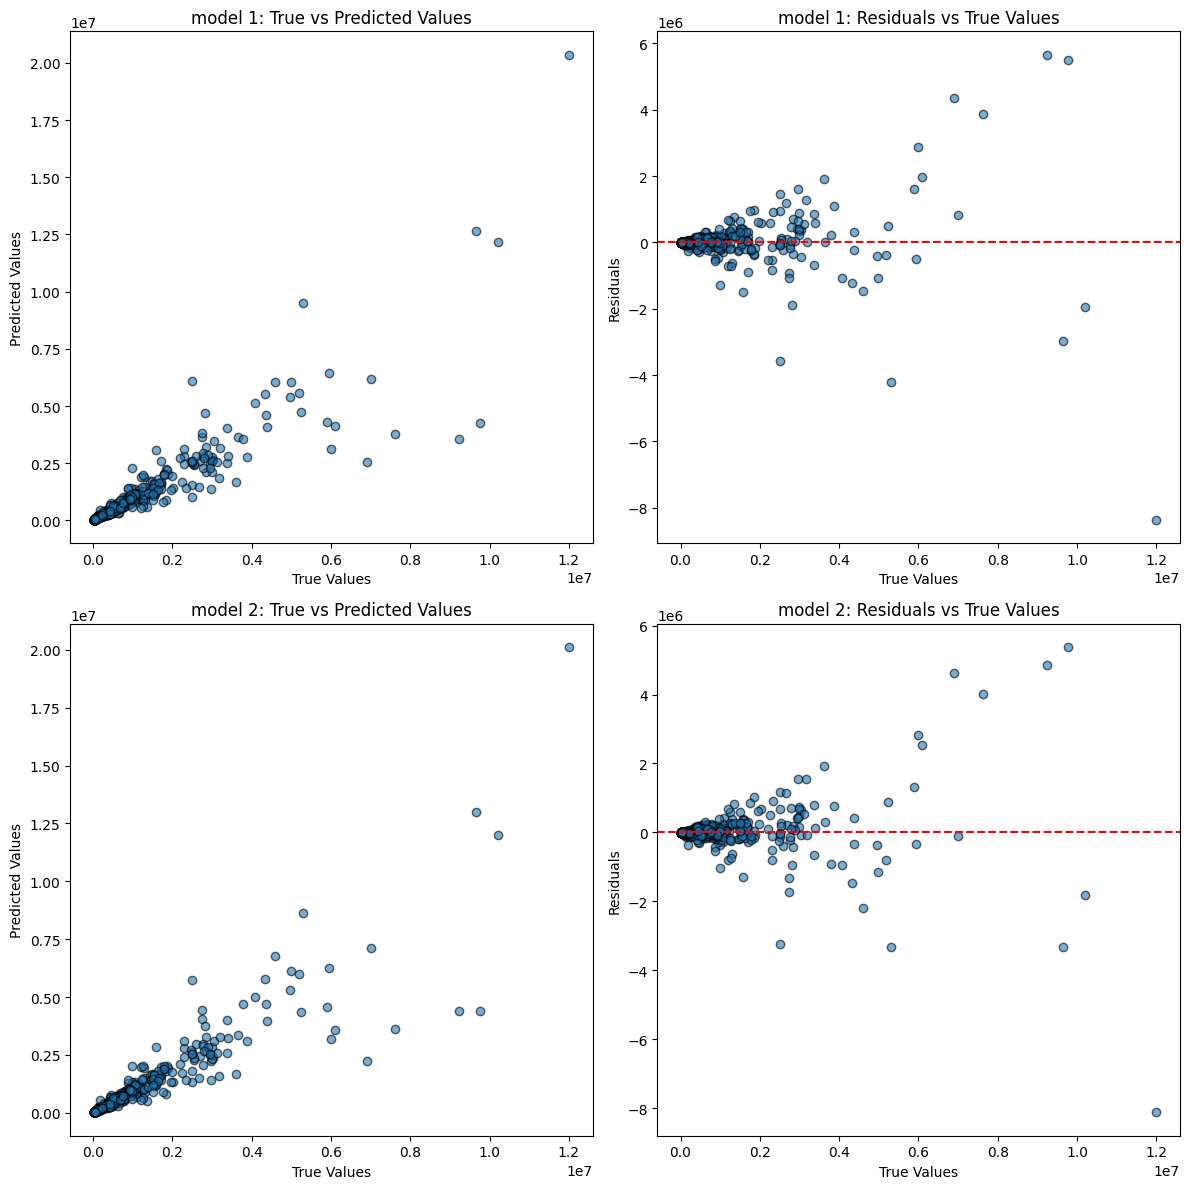

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, model in enumerate(test_results.keys()):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


Even after trying many models and hyperparamters, we find that:
1. The RMSE is higher than MAE because there are bigger errors on the higher price scale and RMSE penalizes that while MAE treats all errors as equal.

In [64]:
preprocessor = pipeline.named_steps['preprocessor']
feature_names = (
    numerical_cols + 
    binary_cat_cols + 
    list(preprocessor.named_transformers_['cat_encoder'].get_feature_names_out(multi_cat_cols))
)

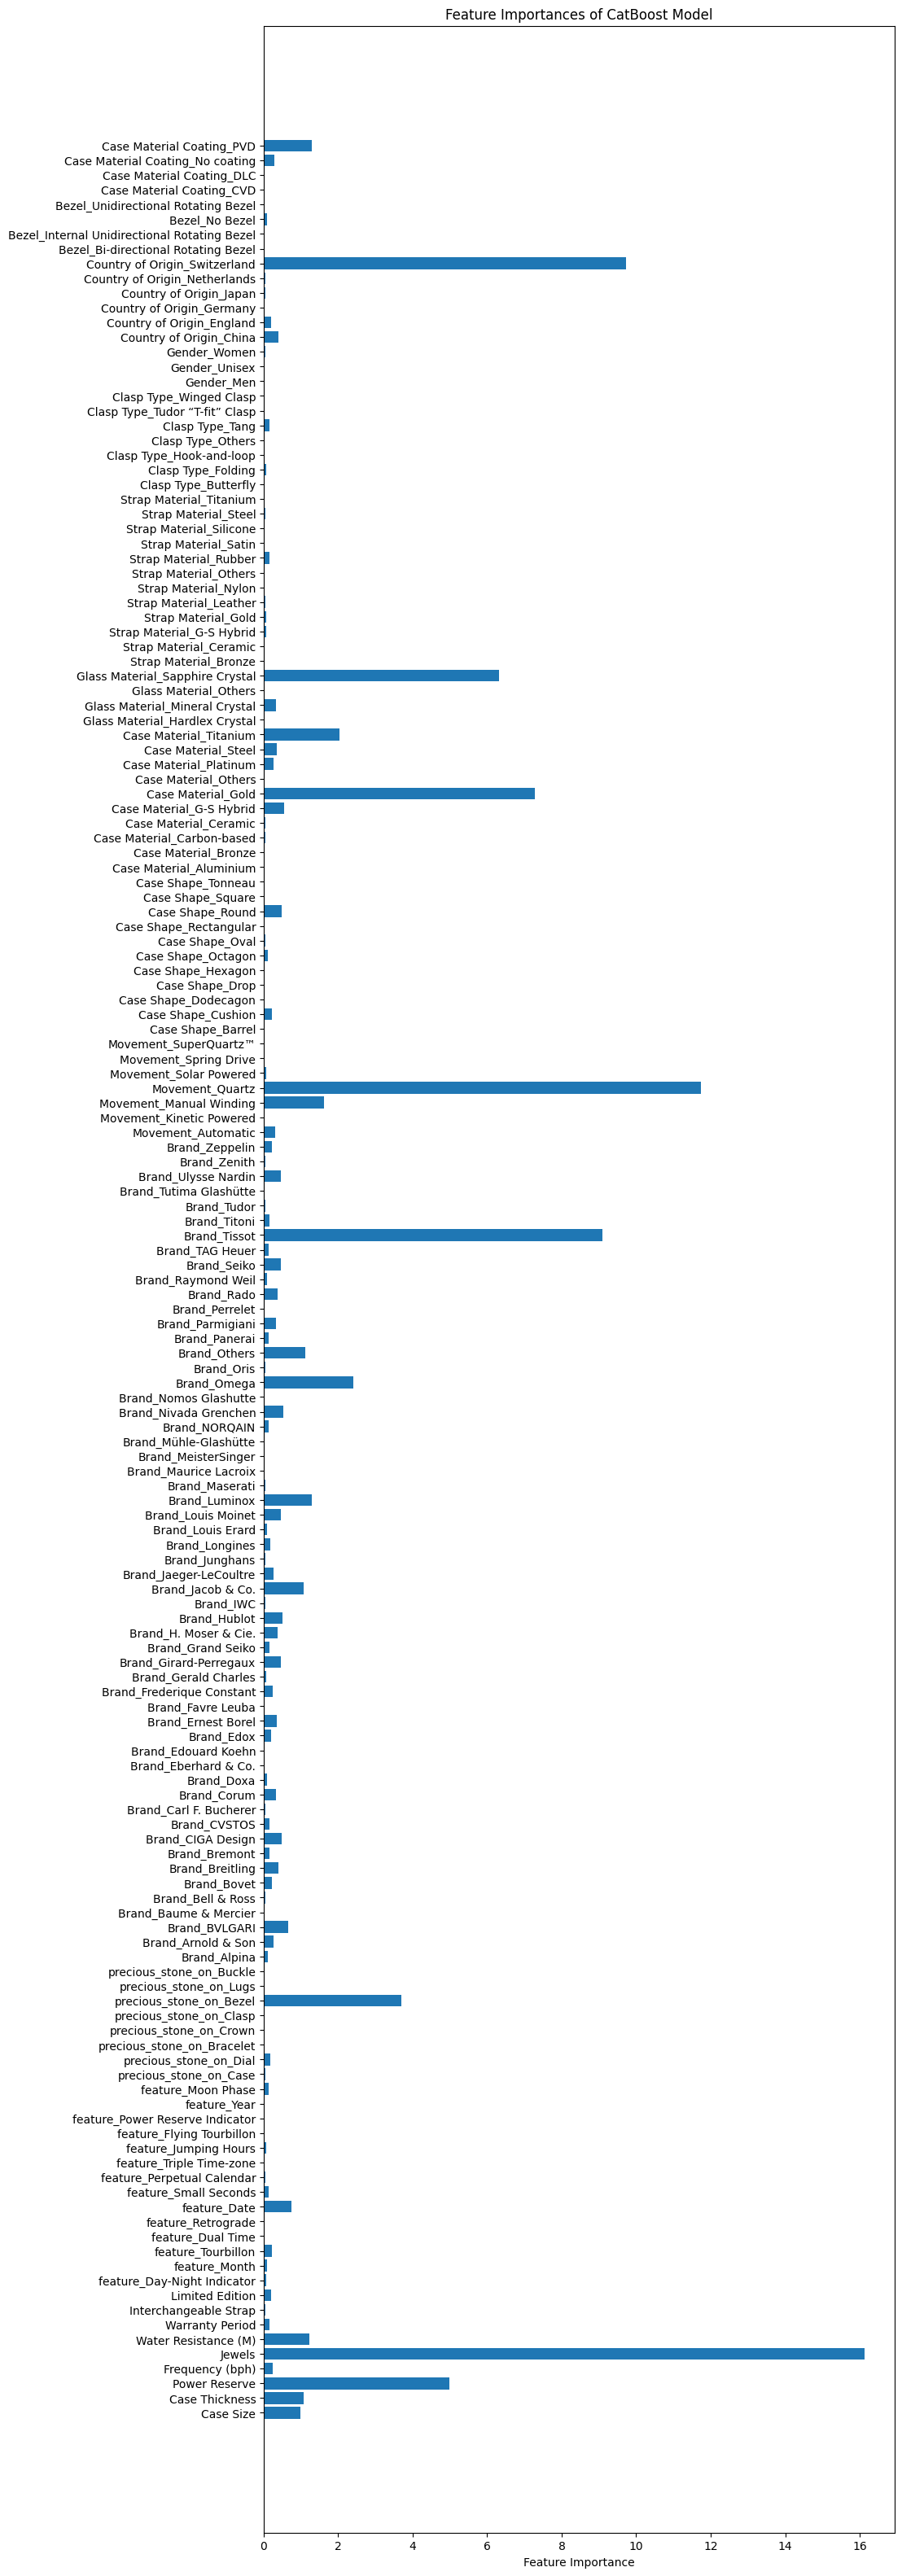

In [65]:
feature_importances = pipeline['regressor'].get_feature_importance()
plt.figure(figsize=(10, 40))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances of CatBoost Model')
plt.show()

We see some features not being very important, Let's see if we can remove them

In [43]:
features_to_remove = ['feature_Power Reserve Indicator', 'precious_stone_on_Case', 'precious_stone_on_Crown', 'precious_stone_on_Clasp', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Dual Time', 'feature_Flying Tourbillon', 'feature_Year', 'Bezel']

In [45]:
mlflow.set_experiment("Feature Removal")

<Experiment: artifact_location='mlflow-artifacts:/451000193621501641', creation_time=1733227901291, experiment_id='451000193621501641', last_update_time=1733227901291, lifecycle_stage='active', name='Feature Removal', tags={}>

In [46]:
def run_feature_removal_experiment(X, Y_log, features_to_remove, params):
    X_full = X.copy()
    
    experiment_strategies = [
        [],
        
        features_to_remove,
        
        *[list(combo) for r in range(1, min(len(features_to_remove), 4))
          for combo in itertools.combinations(features_to_remove, r)]
    ]
    
    results = []
    
    for removed_features in experiment_strategies:
        with mlflow.start_run(nested=True):
            X_processed = X_full.drop(columns=luminosity+removed_features)
            
            binary_cat_cols = [
                col for col in X_processed.columns
                if X_processed[col].nunique() == 2
            ]
            
            multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns
            
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num_scaler', StandardScaler(), numerical_cols),
                    ('binary_cols', 'passthrough', binary_cat_cols),
                    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
                ])
            
            final_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', CatBoostRegressor(**params))
            ])
            
            cv_results = cross_validate(
                final_pipeline, X_processed, Y_log, 
                scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                cv=5, return_train_score=True
            )
            
            mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
            mean_rmse = np.sqrt(mean_mse)
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            
            mlflow.log_param('removed_features', str(removed_features))
            mlflow.log_metric("cv_mean_mse", mean_mse)
            mlflow.log_metric("cv_mean_rmse", mean_rmse)
            mlflow.log_metric("cv_mean_mae", mean_mae)
            
            results.append({
                'removed_features': removed_features,
                'mean_mse': mean_mse,
                'mean_rmse': mean_rmse,
                'mean_mae': mean_mae
            })
            
            print(f"Removed Features: {removed_features}")
            print(f"Mean MSE: {mean_mse}")
            print(f"Mean RMSE: {mean_rmse}")
            print(f"Mean MAE: {mean_mae}")
            print("-" * 50)
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('mean_rmse')
    
    return results_df

In [47]:
results = run_feature_removal_experiment(
        X, Y_log, features_to_remove, params)

Removed Features: []
Mean MSE: 0.07507735740197374
Mean RMSE: 0.27400247699970476
Mean MAE: 0.19001965002314544
--------------------------------------------------
🏃 View run angry-crab-512 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/fc21e2454b054918ad447686b96d89ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Case', 'precious_stone_on_Crown', 'precious_stone_on_Clasp', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Dual Time', 'feature_Flying Tourbillon', 'feature_Year', 'Bezel']
Mean MSE: 0.08047215160049472
Mean RMSE: 0.2836761385814724
Mean MAE: 0.19406903653375793
--------------------------------------------------
🏃 View run whimsical-duck-267 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/a3746a9dc16647bda7de0e7fe2b10e04
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4510001936215016

Removed Features: ['feature_Power Reserve Indicator', 'feature_Flying Tourbillon']
Mean MSE: 0.07750393642590243
Mean RMSE: 0.2783952880813582
Mean MAE: 0.19140322422799802
--------------------------------------------------
🏃 View run respected-turtle-234 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/115bddedf5044a2e9cdf76076c4474c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'feature_Year']
Mean MSE: 0.07809582326479783
Mean RMSE: 0.2794562993829229
Mean MAE: 0.19150467754417216
--------------------------------------------------
🏃 View run bemused-smelt-42 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/f13abbb09f0b42d3b4b8c7aefc4c857c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'Bezel']
Mean MSE: 0.07740936668662876
Mean RMSE: 0.2782253882855207
Mean MAE: 0.19222482271423072
----

Removed Features: ['precious_stone_on_Clasp', 'precious_stone_on_Bracelet']
Mean MSE: 0.07840721425624506
Mean RMSE: 0.2800128823040916
Mean MAE: 0.1916967602813074
--------------------------------------------------
🏃 View run bald-crab-948 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/1df14ab4522a41f993660683940848b1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'precious_stone_on_Buckle']
Mean MSE: 0.08013800396781072
Mean RMSE: 0.2830865662086612
Mean MAE: 0.19212667940018777
--------------------------------------------------
🏃 View run efficient-shad-684 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/876a9406f4544111a2bfe7f39fc891dc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'feature_Triple Time-zone']
Mean MSE: 0.07843987087182144
Mean RMSE: 0.2800711889356373
Mean MAE: 0.19228105686067534
--

Removed Features: ['feature_Triple Time-zone', 'feature_Year']
Mean MSE: 0.07972934928143581
Mean RMSE: 0.2823638597296683
Mean MAE: 0.19265529797309813
--------------------------------------------------
🏃 View run redolent-pig-326 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/73bcab6568984bdfacc668b9bf5e0e3e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Triple Time-zone', 'Bezel']
Mean MSE: 0.07715384921812055
Mean RMSE: 0.27776581722400717
Mean MAE: 0.1914026890490205
--------------------------------------------------
🏃 View run efficient-moose-738 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/2c6b3f7707be4def99b4e9569153c8ca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Dual Time', 'feature_Flying Tourbillon']
Mean MSE: 0.07954426642816335
Mean RMSE: 0.28203593109418407
Mean MAE: 0.1929698580604128
---------------------------------

Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Crown', 'feature_Triple Time-zone']
Mean MSE: 0.07829280233336378
Mean RMSE: 0.27980851011605024
Mean MAE: 0.19222720706585125
--------------------------------------------------
🏃 View run treasured-foal-867 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/c12ad1c01bc040ce883672a1b5eed486
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Crown', 'feature_Dual Time']
Mean MSE: 0.07823790323216447
Mean RMSE: 0.27971039171286516
Mean MAE: 0.19082128295170145
--------------------------------------------------
🏃 View run enthused-crow-284 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/d91b760b5c534ab3a7198a6cd15c4ffb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Crown', 'feature_Flying T

Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Buckle', 'feature_Dual Time']
Mean MSE: 0.07660400015280902
Mean RMSE: 0.2767742765374142
Mean MAE: 0.19046135307655127
--------------------------------------------------
🏃 View run useful-whale-991 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/f1d3ac84794b49a7a8e0906a9d278789
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Buckle', 'feature_Flying Tourbillon']
Mean MSE: 0.07925016108939983
Mean RMSE: 0.2815140513178691
Mean MAE: 0.19233144719860112
--------------------------------------------------
🏃 View run melodic-bear-520 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/efaff90e18c2483c9c011b5b77d6e21e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Buckle', 'feature_Year']
Me

Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Crown', 'feature_Flying Tourbillon']
Mean MSE: 0.08004306118875434
Mean RMSE: 0.2829188243803412
Mean MAE: 0.1936126427285268
--------------------------------------------------
🏃 View run grandiose-ant-274 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/599b9c1aa6ee4c8fbf66c1f684fb1a97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Crown', 'feature_Year']
Mean MSE: 0.08189877826194793
Mean RMSE: 0.28617962586799905
Mean MAE: 0.19322178673600135
--------------------------------------------------
🏃 View run burly-chimp-78 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/5e6c71ed688949e28123a8b898d8a8bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Crown', 'Bezel']
Mean MSE: 0.0811474740181362
Mean RMSE: 0.284

Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Buckle', 'feature_Year']
Mean MSE: 0.07939239007007595
Mean RMSE: 0.2817665524331729
Mean MAE: 0.192114247356329
--------------------------------------------------
🏃 View run flawless-gnu-211 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/434b897b31ff4bb6bf8a4d25935062d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Buckle', 'Bezel']
Mean MSE: 0.08154842537629153
Mean RMSE: 0.28556684922499587
Mean MAE: 0.1957670100504992
--------------------------------------------------
🏃 View run unequaled-goat-166 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/00891d8a08a9477784efb3843c373b0b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'feature_Triple Time-zone', 'feature_Dual Time']
Mean MSE: 0.08331231958238994
Mean RMSE: 0.288638

Removed Features: ['precious_stone_on_Crown', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle']
Mean MSE: 0.07909212579409317
Mean RMSE: 0.2812332231335643
Mean MAE: 0.19059294206946936
--------------------------------------------------
🏃 View run bedecked-moose-511 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/0fdcd616cf87438b80ddef67dcc8956e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Crown', 'precious_stone_on_Bracelet', 'feature_Triple Time-zone']
Mean MSE: 0.08004501957059482
Mean RMSE: 0.28292228539051995
Mean MAE: 0.19258162000130358
--------------------------------------------------
🏃 View run big-moose-528 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/cfd65f193b3a4695accd81b454f3732e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Crown', 'precious_stone_on_Bracelet', 'feature_Dual Time']
Mean MSE:

Removed Features: ['precious_stone_on_Crown', 'feature_Flying Tourbillon', 'Bezel']
Mean MSE: 0.07653137930094266
Mean RMSE: 0.27664305395390404
Mean MAE: 0.18997719809100264
--------------------------------------------------
🏃 View run invincible-bear-148 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/1a3e4e62e4b842b588f6fb9c4e1a5c34
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Crown', 'feature_Year', 'Bezel']
Mean MSE: 0.07704462940474513
Mean RMSE: 0.2775691434665336
Mean MAE: 0.19018710014738688
--------------------------------------------------
🏃 View run shivering-mare-306 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/4ca422f584434ffa82cd37f7b3646430
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle']
Mean MSE: 0.08010293181352648
Mean RMSE: 0.283024

Removed Features: ['precious_stone_on_Clasp', 'feature_Dual Time', 'Bezel']
Mean MSE: 0.07970924392815104
Mean RMSE: 0.2823282556318992
Mean MAE: 0.19286643929889552
--------------------------------------------------
🏃 View run upbeat-squirrel-280 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/61f83881d99849848c21fd2bad50550e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'feature_Flying Tourbillon', 'feature_Year']
Mean MSE: 0.0783224244343692
Mean RMSE: 0.2798614379194983
Mean MAE: 0.19245944366818038
--------------------------------------------------
🏃 View run illustrious-wasp-948 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/027523c2365247c3ad32dabf58a1f036
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'feature_Flying Tourbillon', 'Bezel']
Mean MSE: 0.07648877697787863
Mean RMSE: 0.27656604451356

Removed Features: ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Dual Time']
Mean MSE: 0.07755209994918913
Mean RMSE: 0.2784817766913827
Mean MAE: 0.1906041323886043
--------------------------------------------------
🏃 View run handsome-ant-876 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/10df7ea36f5e40fb81203f8ca898be38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Flying Tourbillon']
Mean MSE: 0.07447329067903566
Mean RMSE: 0.2728979492026931
Mean MAE: 0.18725545142496577
--------------------------------------------------
🏃 View run clumsy-zebra-66 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/3d761425f77a4c14b2c56e3215962fc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Year']
Mean MSE: 0.0798191514882

After experimentation, we found that followinf columns can be dropped

In [55]:
features_to_remove = ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Flying Tourbillon']

In [57]:
with mlflow.start_run(nested=True):
    X_processed = X.drop(columns=luminosity+features_to_remove)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]

    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(**params))
    ])



    cv_results = cross_validate(
            pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
            cv=5, return_train_score=True
        )
    mlflow.log_param('model', model_name+"7")
    mlflow.log_params(params)
    
    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_r2 = cv_results['test_r2'].mean()

    mlflow.log_param("name", "base")
    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_mean_r2", mean_r2)
    mlflow.log_param('removed_features', str(features_to_remove))

    print(f"Removed Features: {features_to_remove}")
    print(f"Model {name}:")
    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Mean R2:", mean_r2)

Removed Features: ['precious_stone_on_Crown', 'feature_Triple Time-zone', 'feature_Year']
Mean MSE: 0.07463568721929088
Mean RMSE: 0.27319532796021767
Mean MAE: 0.18751552907248345
--------------------------------------------------
🏃 View run polite-colt-143 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/2c95ccb911484b018e0a4a2ed76eed9d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641


## Final Model

In [71]:
params = {
        'iterations': 1500,
        'learning_rate':  0.1642852035875127,
        'depth': 4,
        'l2_leaf_reg': 4,
        'rsm': 0.8263126640848959,
        'random_strength': 0.658651292068157,
        'bagging_temperature': 0.12208059366638693,
        'border_count': 64,
        'verbose':0,
        'loss_function': 'RMSE'
    }

In [82]:
X = df.drop(['price','precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Flying Tourbillon'], axis=1)
Y = df['price']
Y_log = np.log1p(Y)

numerical_cols = ['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']
categorical_cols = X.drop(columns=['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']).columns.tolist()

luminosity = []

for col in df.columns:
    if 'luminosity' in col:
        luminosity.append(col)

In [83]:
X = X.drop(columns=[])

binary_cat_cols = [
    col for col in X.columns
    if X[col].nunique() == 2
]

multi_cat_cols = X.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_log, test_size=0.2, random_state=32)

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  

mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

r2 = r2_score(y_test_orig, y_pred_orig)
print("r2:", r2)

MSE: 73214586229.5893
RMSE: 270581.9399545899
MAE: 97833.00630197123
r2: 0.9400412115757313


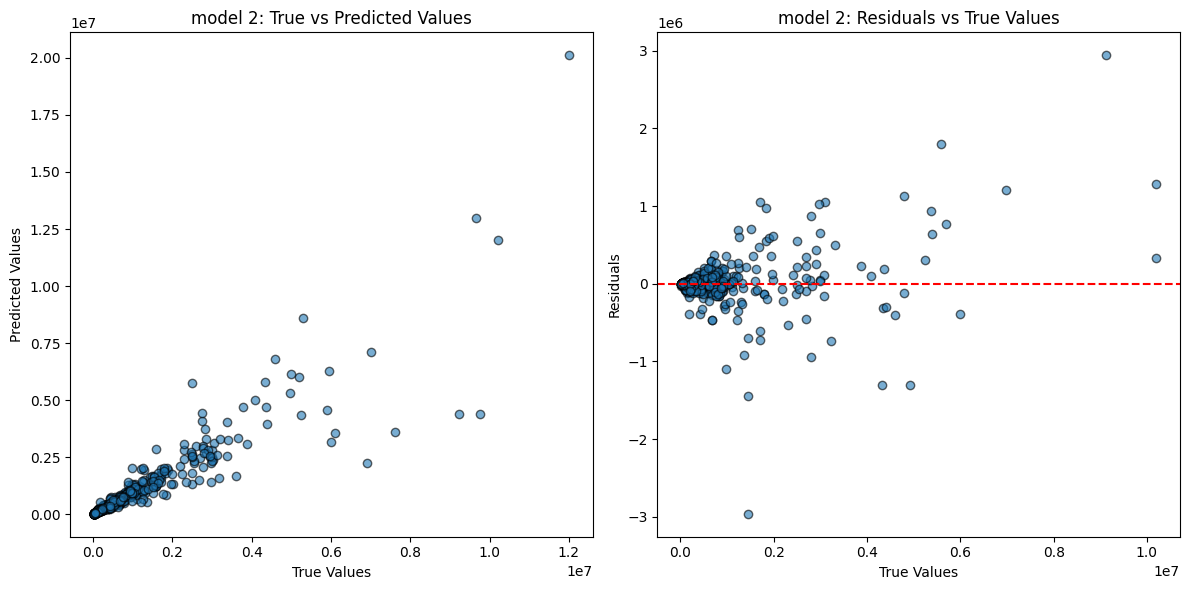

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

residuals = y_test_orig - y_pred_orig

ax1 = axes[0]
ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predicted Values")
ax1.set_title(f"{model}: True vs Predicted Values")

ax2 = axes[1]
ax2.scatter(y_test_orig, residuals, alpha=0.6, edgecolor='k')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals")
ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()

In [87]:
def predict_price(inputs):
    columns = X.columns
    
    new_data = pd.DataFrame([inputs], columns=columns)
    prediction = final_pipeline.predict(new_data)

    return np.expm1(prediction)[0]

In [90]:
inputs = X.iloc[1].values.tolist()
predict_price(inputs)

2159629.872216657

In [91]:
Y.iloc[1]

2000000

In [69]:
import pickle

with open('trained_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

with open('columns.pkl', 'wb') as f:
    pickle.dump(X.columns, f)